## Gaussian Process Demonstration for High-Throughput X-ray Diffraction Data Analysis
Written by Carl Strandby, Chalmers University of Technology, for a Project Course on data processing in Material's Science in 2023. Email: carstran@student.chalmers.se or carl.strandby@gmail.com

This Jupyter Notebook demonstrates how Gaussian Processes can speed up the analysis of measurement data by implementing importance sampling. The work is based on replicating the findings of Shingo Maruyama, Kana Ouchi, Tomoyuki Koganezawa, and Yuji Matsumoto in the paper [High-Throughput and Autonomous Grazing Incidence X-ray Diffraction Mapping of Organic Combinatorial Thin-Film Library Driven by Machine Learning](https://pubs.acs.org/doi/10.1021/acscombsci.0c00037?goto=supporting-info) published in ACS Combinatorial Science. The underlying theory comes from the course Advanced Simulations and Machine Learning held by Paul Erhart at Chalmers University and the authors' solution of a homework problem in this course written together with Tobias Hainer.

---
## Notebook Overview
    
**1. Experiment Description**

    An introduction to the high-throughput X-ray diffraction experiment by Maruyama et al., outlining the key aspects and objectives.**

**2. Introduction to Gaussian Processes and Bayesian Optimization**

    A theoretical foundation on Gaussian Processes and Bayesian Optimization, focusing on their application in importance sampling.

**3. Generating Realistic Sample Data**

    The methodology for creating realistic 2D diffraction data, simulating the environment investigated by Maruyama et al.

**4. Performing a Conventional Grid Search**

    Execution of a conventional grid search as a traditional, numerically intensive benchmark for comparison with Bayesian Optimization.

**5. A Detour into Stochastic Gradient Descent**

    Insights into Stochastic Gradient Descent and its application in this study for suggesting sampling coordinates.

**6. Application of Bayesian Optimization with Gaussian Processes**

    Detailed application of Bayesian Optimization, demonstrating the effective use of Gaussian Processes for sampling intensity distributions.

**7. Comparison of Exploration/Exploitation Sampling Strategies**

    A comparative analysis of various sampling strategies, evaluating their balance of exploration and exploitation in the context of Bayesian Optimization and sampling efficiency.

**8. Future Improvements**

    A discussion on the limitations of the current approach, with suggestions for potential refinements and future research directions.


---
## Learning Outcomes
By the end of this notebook, you will have a comprehensive understanding of Gaussian Process methodology and its applications in data analysis, alongside a practical insight into how it offers advantages over traditional methods in the field of materials science.

--- 
## 1. Experiment Description

In the experiment performed by Maruyama et al. a synchrotron microbeam X-ray was used for Grazing Incidence X-ray Diffraction (GIXD) measurements. This technique was employed to examine the structural properties of organic thin films, specifically those composed of the matrix material, Dinaphthothienothiophene (DNTT), doped with varying concentrations of 8-Hydroxyquinolinolato-lithium (Liq). A material was designed with a two-dimensional variation; along one axis (x-axis) the concentration of Liq doping was varied, and along the other axis (y-axis), the growth temperature was altered. This setup created a grid of unique material compositions each representing a different combination of Liq concentration and growth temperature.

During the GIXD mapping process each grid point was analyzed individually. The synchrotron X-ray beam incident on these points produced diffracted X-rays captured by a 2D area detector. Changes in the growth temperature and Liq concentrations in the thin film material results in variations in electronic and structural properties of the thin films. These alterations could manifest as differences in crystallinity, phase composition, and molecular orientation, all of which are discernible in the GIXD patterns. Similarly, the growth temperature impacts the crystalline structure by affecting crystal size, orientation, and the presence of defects.The changes in the crystallinity levels influence the peak intensities in these diffraction patterns, which in the experiment was used to extract three feature intensities corresponding to two different DNTT phases and one Liq phases, in this work labelled DNTT-A, DNTT-B and Liq, respectively, from the GIXD patterns.

Later in this notebook, we will explore how various exploration and exploitation strategies can be applied, depending on whether the focus is on a specific peak intensity in one intensity map or on understanding the interplay between different intensity maps. Emphasis will be on employing efficient sampling techniques to pinpoint composition coordinates that correspond to crystallinity maxima for the three features; DNTT-A, DNTT-B, and Liq.

--- 
## 2. Short introduction to Gaussian Processes and Bayesian optimization

### A) Gaussian Processes

Gaussian Processes (GPs) represent a class of mathematical models that predict outputs based on inputs and targets using a collection of kernel functions. The process can be compared with Machine Learning methods, but GPs differ in that they don't rely on continuously adjusted weights. Instead they estimate the similarity of input data so that inputs with similar targets are considered similar.

Similarity is quantified by the kernel functions, forming the core of GP models. Bias kernels can be used to provide a constant offset, akin to an intercept parameter when fitting a linear slope to data. Radial Basis Functions (RBFs) are commonly the primary functions used. Just like sine functions, they can be visualized as oscillating functions, but where a sine function would have a fixed frequency and amplitude, the RBFs' frequencies and amplitudes are allowed to vary over distances longer than a lengthscale parameter. Therefore, at a scale larger than the length scale RBFs exhibit complex oscillations, but appear as sine waves when viewed at a closer range.

In this work, a GP model is constructed with selected kernels, including bias kernels and RBF kernels, and fits its basis functions to match target data as closely as possible. In theory, a GP model consists of an infinite number of basis functions, which is why some people envision them as a single layer neural network of infinite length. The fitted basis functions will naturally converge at sampled points and diverge for configurations where the model has yet to see any measurements. The mean, $\mu$, of all fitted basis functions is simply adopted as the GP models prediction, representing the best current approximation. Significantly, the uncertainty, $\sigma$ of the prediction can be quantified from the variance of the fitted basis functions, again lower in areas with dense target data and higher where data is sparse.

The rate of change of the GP model's prediction will primarily be impacted by the models current lengthscale parameter and it's variance parameter. The variance parameter controls the penalty for RBFs diverging from the target data. If the lengthscale is larger than the length of features in the gathered data, the RBFs naturally can't intersect all targets, the variance parameter would then guide the RBFs to be more similar in regions with more data. Conversely, if the variance parameter would be very large, the RBFs would not be incentivized to fit targets at all and there would be nothing to guide the lengthscale parameter, while a very small variance parameter would incentivize the RBFs to overfit. Therefore, the lengthscale and variance parameters are first optimized before a model is used to make a prediction.


### B) Bayesian optimization

Bayesian Optimization is based on the Bayesian principle of updating beliefs based on new evidence. In this work, Bayesian Optimization is used to guide the collection of datapoints based on GP model predictions. The process begins by performing initial measurements that are used to initialize the GP model, with the number and positions of initial measurements making up hyperparameters that should be optimized for the application in question. After the model has been initialized, it's kernels RBFs fitted and lengthscale and variance parameters updated, the predicted mean and uncertainty, $\mu$ and $\sigma, is used to calculate an acquisition function $A$ as

\begin{equation}
    A = \mu + \kappa \sigma,
\end{equation}

where $\kappa \in [0,\infty)$ is a weight parameter known as the exploration\exploitation parameter. For small values of $\kappa$ the acquisition function will predominantly exhibit the mean's features, for large values the uncertainties' features and a mix for values inbetween. In Bayesian Optimization one performs Gradient Descent on the acquisition function and uses its' maxima to propose the next measurement location. Each new point is then used to refine the GP model, enhancing the accuracy of the prediction $\mu$ and reducing the uncertainty in sampled regions. This process iteratively reshapes the acquisition function landscape, guiding the subsequent proposed measurements. 

The setting of the exploration/exploitation parameter $\kappa$ allows for design of different sampling strategies. For instance, an exploration-focused strategy with a high kappa value emphasizes reducing uncertainty, while an exploitation-focused strategy with a low kappa prioritizes identifying optimal points. The design of suitable strategies requires some consideration of nuances as a too low value of $\kappa$ can lead to the sampling converging to a local minima. A balanced approach might be to use a fixed $\kappa$ that initially incorporates both mean and uncertainty features in the acquisition function, and as the uncertainty is reduced as more samples are added the focus is naturally shifted to sample regions with a large mean. Other more complex strategies can involve changing $\kappa$ over time, either increasing to maintain a balance between exploration and exploitation or decreasing to transition from a broad search to concentrate on sampling at identified maxima.


---
## 3. Generation of Realistic Sample Data

The first step in our analysis involves generating realistic sample data. Our focus here is on creating three distinct intensity maps, each representing intensities of different features from a single GIXD measurement.

To add authenticity we introduce some of noise and distortions, drawing inspiration from the calibration measurements detailed in Maruyama et al.’s study. Their experiment utilized 2mm x 2mm gold (Au) squares on a SiO2/Si substrate to assess measurement errors. In particular they observed a smearing of intensity along the y-axis, which aligns parallel to the X-ray beam during measurements. This smearing effect was presumed to arise from the experimental setup, and thefore anisotropic noise is added. As a side note, a consequence of this anisotropy is the benefit of aligning the most significant property along the x-axis, here the Liq concentration instead of growth temperature. 

In [1]:
# Importing packages
#
####################################################################################################


# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pandas as pd


# Benchmark and optimization libraries
import time as time
from tqdm import tqdm
from joblib import Parallel, delayed


# Sample generation libraries
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter


# Convenventional optimization libraries for grid search
from scipy.optimize import minimize
from scipy.interpolate import griddata, Rbf

# Gaussian process libraries
import GPy


####################################################################################################
#
# Setting the standard plot style
#
####################################################################################################

def set_plot_style():
    
    """
    Description:
    Sets the plot style to a standard style that is suitable for LaTeX documents.
    
    Input:
    None
    
    Output:
    None
    
    """
    
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette("deep")
    sns.set(font='sans-serif')
    
    fig_width  = 3.5
    fig_height = 3.5

    plt.rcParams['figure.figsize'] = (fig_width, fig_height)
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['font.size'] = 2 * fig_width
    
    # Set grid lines off
    plt.rcParams['axes.grid'] = True

set_plot_style()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Functions to generate gaussian peaks to function as the true signal
#
####################################################################################################


def gaussian_peak(X, Y, mean, cov):
    
    """
    Description:
    Generate a Gaussian peak with the specified mean and covariance matrix.
    
    Inputs:
    X (np.ndarray): Stacked 2D array of x-coordinates
    Y (np.ndarray): Stacked 2D array of y-coordinates
    mean (tuple): Mean of the Gaussian peak
    cov (list): Covariance matrix of the Gaussian peak
    
    Outputs:
    peak (np.ndarray): 2D array of the Gaussian peak
    
    """
    
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean, cov)
    
    return rv.pdf(pos)




def elliptical_gaussian_peak(X, Y, center, axes_lengths, angle_peak):
    
    """
    Description:
    Generate an elliptical Gaussian peak with the specified mean and covariance matrix.
    
    Inputs:
    X (np.ndarray): Stacked 2D array of x-coordinates
    Y (np.ndarray): Stacked 2D array of y-coordinates
    center (tuple): Center of the Gaussian peak
    axes_lengths (list): Lengths of the axes of the Gaussian peak
    angle_peak (float): Angle of the peak of the Gaussian peak
    
    Outputs:
    peak (np.ndarray): 2D array of the elliptical Gaussian peak
    
    """
    
    # Convert peak angle to Cartesian coordinates for the mean
    angle_rad = np.radians(angle_peak)
    mean_x = center[0] + axes_lengths[0] * np.cos(angle_rad)
    mean_y = center[1] + axes_lengths[1] * np.sin(angle_rad)
    mean = [mean_x, mean_y]
    
    # Create an elliptical Gaussian along the specified axes
    cov_matrix = [
        [axes_lengths[0]**2, 0],
        [0, axes_lengths[1]**2]
    ]
    rotated_cov = get_rotated_cov(cov_matrix, angle_peak + 90)
    
    # Generate the Gaussian peak
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean, rotated_cov)
    
    return rv.pdf(pos)




def get_rotated_cov(cov, angle):
    
    """
    Description:
    Generate a rotated covariance matrix.
    
    Input:
        cov (list): Covariance matrix to be rotated
        angle (float): Angle of rotation
    
    Output:
        rotated_cov (list): Rotated covariance matrix
    
    """
    
    theta = np.radians(angle)  # Convert to radians
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    return rotation_matrix @ cov @ rotation_matrix.T




def binary_square_peak(X, Y, center, length, height):
    
    """
    Description:
    Generate a binary square peak.
    
    Inputs:
    X (np.ndarray): Stacked 2D array of x-coordinates
    Y (np.ndarray): Stacked 2D array of y-coordinates
    center (tuple): Center of the square peak
    length (float): Length of the square peak
    height (float): Height of the square peak
    
    Outputs:
    peak (np.ndarray): 2D array of the square peak
    
    """

    peak = np.zeros_like(X, dtype=float)
    
    x_min = center[0] - length / 2
    x_max = center[0] + length / 2
    y_min = center[1] - height / 2
    y_max = center[1] + height / 2
    
    peak[(X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)] = 1
    
    return peak


In [3]:
# Function to add noise and distortions to the input map
#
####################################################################################################


def add_noise_and_distortions(input_map, noise_level, smear_intensity_y, smear_intensity_x):
    
    """
    Description:
    Add noise and distortions to the input map.
    
    Inputs:
    input_map (np.ndarray): 2D array of the input map
    noise_level (float): Level of noise to be added
    smear_intensity_y (float): Intensity of smearing along the y-axis
    smear_intensity_x (float): Intensity of smearing along the x-axis
    
    Outputs:
    smeared_map (np.ndarray): 2D array of the smeared map
    
    """
    
    np.random.seed(42)
   
    # Add random noise
    noisy_map = input_map + noise_level * np.random.rand(*input_map.shape)
    
    # Subtract some random noise
    noisy_map -= noise_level * np.random.rand(*input_map.shape)
    
    # Smear intensity along both the y-axis and x-axis to simulate the smearing effect
    smeared_map = gaussian_filter(noisy_map, sigma=[smear_intensity_y, smear_intensity_x])
    
    return smeared_map




In [4]:
# Function to get the maximum of an intensity map
#
####################################################################################################


def get_intensity_map_maximum(intensity_map, x_lin, y_lin):
    
    """
    Description:
    Get the indices and coordinates of the maximum of the intensity map.
    
    Inputs:
    intensity_map (np.ndarray): 2D array of the intensity map
    x_lin (np.ndarray): 1D array of the x-coordinates of the intensity map
    y_lin (np.ndarray): 1D array of the y-coordinates of the intensity map
    
    Outputs:
    max_indices (tuple): Indices of the maximum of the intensity map
    max_coords (tuple): Coordinates of the maximum of the intensity map
    
    """
    max_indices_switched = np.unravel_index(np.argmax(intensity_map), intensity_map.shape)
    max_indices = (max_indices_switched[1], max_indices_switched[0])
    max_coords = (x_lin[max_indices[0]], y_lin[max_indices[1]])
    
    return max_indices, max_coords

In [5]:
# Function to plot intensity maps
#
####################################################################################################

def plot_intensity_maps(intensity_maps, x, y, max_indices=None, true_indices = None, labels=None):
    
    """
    Description:
    Plot the intensity maps.
    
    Inputs:
    intensity_maps (list): List of 2D arrays of the intensity maps
    x (np.ndarray): 1D array of the x-coordinates of the intensity maps
    y (np.ndarray): 1D array of the y-coordinates of the intensity maps
    max_indices (list): List of tuples of the indices of maximum to be labeled as max
    true_indices (list): List of tuples of the indices of maximum to be labeled as true
    labels (list): List of labels for the intensity maps
    
    Outputs:
    None
    
    """
    
    fig, axes = plt.subplots(1, len(intensity_maps), figsize=(3.5*len(intensity_maps), 3.5))
    
    # If there's only one intensity map, axes will not be a list
    if len(intensity_maps) == 1:
        axes = [axes]

    for i, intensity_map in enumerate(intensity_maps):
        
        # Plot the intensity map
        ax = sns.heatmap(intensity_map, ax=axes[i], cbar=False, cmap='magma')
        ax.invert_yaxis()
        
        # Plot the maximum indices
        if max_indices is not None:
            map_max_indices = max_indices[i]
            if not isinstance(map_max_indices[0], (list, tuple)):
                map_max_indices = [map_max_indices]
                
            for coord_pair in map_max_indices:
                ax.scatter(coord_pair[0], coord_pair[1], marker='x', color='blue', s=100)

            ax.scatter([], [], marker='x', color='blue', s=100, label='Max')
        
        # Plot the true indices
        if true_indices is not None:
            ax.scatter(true_indices[i][0], true_indices[i][1], marker='o', color='red', s=100, label='True', facecolors='none')
        
        # Set ticks, titles and labels
        axes[i].set_xticks(np.linspace(0, len(x), 5))
        axes[i].set_xticklabels(np.round(np.linspace(x[0], x[-1], 5), 2))
        
        axes[i].set_yticks(np.linspace(0, len(y), 5))
        axes[i].set_yticklabels(np.round(np.linspace(y[0], y[-1], 5), 2))
        if labels is not None:
            axes[i].set_title(f'Intensity Map {labels[i]}')
        else:
            axes[i].set_title(f'Intensity Map {i+1}')
            
        # The x-axis label is set to Sample position (mm) instead of Liq. concentration according to the paper
        axes[i].set_xlabel('Sample position (mm)')
        axes[i].set_ylabel('Growth temperature (°C)')
        
        
        axes[i].set_aspect('equal')
        
        # if there are artists to be labeled, add a legend
        if max_indices is not None:
            axes[i].legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    

### A) Generation of true data
First we generate our "perfect" true data. It should be noted that the features here are more concentrated than the three example intensity maps from Maruyama et al. This is because in previous implementations the interpolator used to simulate measurements performed poorly when the Gaussians it tried to interpolate significantly exceeded boundaries. A consequence might be a simpler Bayesian Optimization. This is elaborated on in the chapter 'Future Improvements' and a suggestion is to instead perform measurements by calculating two dimensional mathematical functions instead of interpolating from a grid.

In [6]:
# Define the grid used to generate the intensity maps
n_points_x = 80
n_points_y = 100

x_min, x_max = 0, 15
y_min, y_max = 30, 100

x = np.linspace(x_min, x_max, n_points_x)
y = np.linspace(y_min, y_max, n_points_y)

X, Y = np.meshgrid(x, y)

In [7]:
# Placements and shape of the Gaussian peaks, two simpler and one more complex with elliptical peaks

peaks = [
        {'mean': (11, 70), 'cov': [[10, 0], [0, 500]]},
        {'mean': (4.5, 60), 'cov': [[10, 0], [0, 300]]},
        ]

circular_peaks = [
        {'axes_lengths': [4, 14], 'angular_spread': 40, 'center': (4, 100), 'angle': -60},
        {'axes_lengths': [3, 140], 'angular_spread': 160, 'center': (8, 40), 'angle': 88},
        {'axes_lengths': [4, 3], 'angular_spread': 4, 'center': (4, 40), 'angle': 10},
        ]


# Relative intensities of the three peaks in the third map
relative_intensity = [0.4, 4, 0.12] 

In [8]:
# Generate the intensity maps
ground_truth_maps = [gaussian_peak(X, Y, **peak) for peak in peaks]

third_map = np.zeros_like(X, dtype=float)
for idx, peak in enumerate(circular_peaks):
    elliptical_peak = elliptical_gaussian_peak(X, Y, peak['center'], peak['axes_lengths'], peak['angle'])
    third_map += relative_intensity[idx] * elliptical_peak  # Apply relative intensity here

ground_truth_maps.append(third_map)

ground_truth_maps = [map_ / map_.max() for map_ in ground_truth_maps]


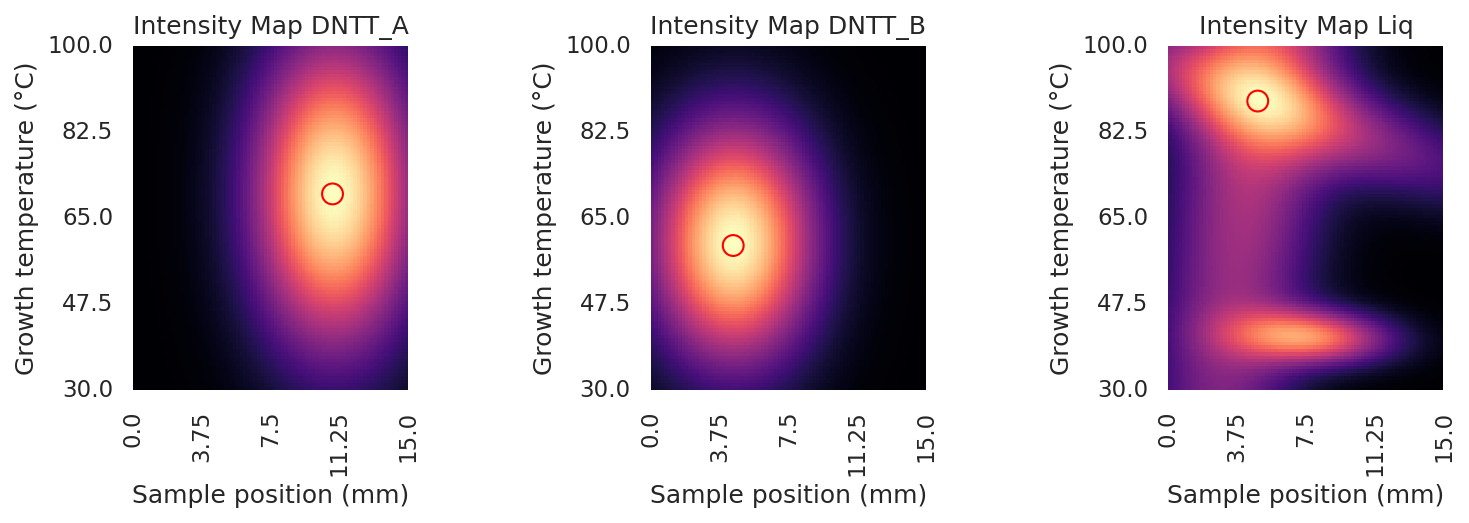

In [9]:
# Set map labels
labels = ['DNTT_A', 'DNTT_B', 'Liq']

# Get the maximum index for each map
max_indices, max_coords = zip(*[get_intensity_map_maximum(map_, x, y) for map_ in ground_truth_maps])

# Plot the intensity maps
plot_intensity_maps(ground_truth_maps, x, y, true_indices=max_indices, labels=labels)

### B) Addition of noise and distortions

Next we add noise and distortions. The smearing is calibrated on the square maps guided by the distinct straight lines of the squares parallel to the x and y-axes. When setting the noise levels, the goal was to achieve realistic data in terms of simulations so that original features are still visible and the intensity maxima slightly perturbed.

In [10]:
# Placements and shape of square peaks
bottom_left = (2.5, 45)
x_spacing = 5
y_spacing = 20
length = x.max()/5
height = y.max()/7

square_peaks = [{'center' : (bottom_left[0] + x_spacing * i, bottom_left[1] + y_spacing * j), 'length' : length, 'height' : height} for i in range(3) for j in range(3)]


In [11]:
# Generate binary square maps
square_map = np.zeros_like(X, dtype=float)
for square in square_peaks:
    square_map += binary_square_peak(X, Y, square['center'], square['length'], square['height'])

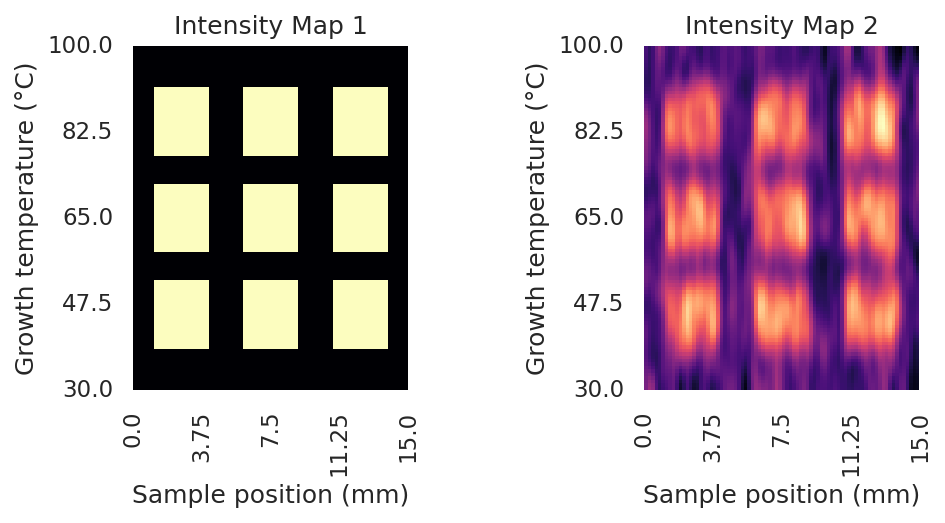

In [12]:
# Parameters for noise and distortion
square_noise_level = 2  # Noise level for the square map
smear_intensity_y = 4  # Smearing effect in grid points along the y-axis
smear_intensity_x = 1  # Smearing effect in grid points along the x-axis


# Apply noise and distortions
noisy_square_map = add_noise_and_distortions(square_map, square_noise_level, smear_intensity_y, smear_intensity_x)


# Plot the maps
plot_intensity_maps([square_map, noisy_square_map], x, y)

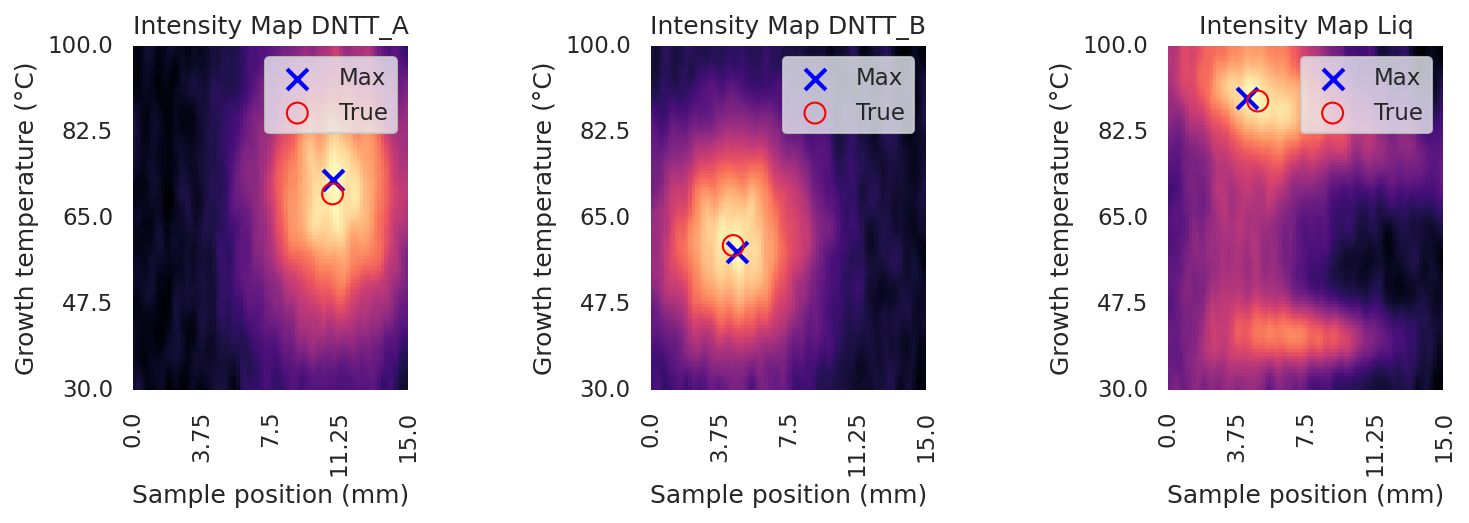

In [13]:
# Parameters for noise and distortion
ground_truth_noise_level = 0.4

# Add noise and distortions to the ground truth maps
noisy_distorted_maps = [add_noise_and_distortions(map_, ground_truth_noise_level, smear_intensity_y, smear_intensity_x) for map_ in ground_truth_maps]

DNTT_A_map = noisy_distorted_maps[0]
DNTT_B_map = noisy_distorted_maps[1]
Liq_map = noisy_distorted_maps[2]

# Get the maximum index for each map
max_indices_noisy, max_coords_noisy = zip(*[get_intensity_map_maximum(map_, x, y) for map_ in noisy_distorted_maps])

# Plot the maps
plot_intensity_maps(noisy_distorted_maps, x, y, max_indices=max_indices_noisy, true_indices=max_indices, labels=labels)

---
## 4.  Performing a Conventional Grid Search

In this section the conventional grid search approach is used to conduct measurements. The primary aim here is to underscore the inherent limitations of grid search, especially in terms of the number of measurements it requires. This method will later serve as a benchmark to highlight the comparative efficiency of Bayesian Importance Sampling in later sections.

To illustrate these points, we examine two different measurement grids; one larger grid comprising 100 measurements and a smaller one with 50 measurements. It's important to note that the resolution and placement of these grid lines can significantly influence the identification of maximas, such as if a grid point by chance is placed on top of a maxima. Therefore the configuration has been chosen to strike a balance between reasonable results, such as maximas in the larger grid being closer to the true maximas compared with the maximas of the smaller grid.

In [14]:
# Functions to generate measurements from the intensity maps
#
####################################################################################################



def perform_grid_search(measurement_grid, intensity_maps):
    
    """
    Description:
    Algorithm to perform a grid search on grid points using RBF interpolation from the intensity maps.
    
    Inputs:
    measurement_grid (list): List of tuples of the grid points to be measured
    intensity_maps (list): List of 2D arrays of the intensity maps
    
    Outputs:
    measured_intensities (pd.DataFrame): DataFrame of the measured coordinates and intensities of the three intensity maps.
    
    """
    
    rbf_interpolators = get_RBF_interpolators(intensity_maps, bounds=[(x_min, x_max), (y_min, y_max)])
    
    measured_intensities = []
    for measurement_coordinate in measurement_grid:
        # Perform a point measurement and interpolate the intensity at the measurement position
        measured_intensities.append(get_measured_intensity(measurement_coordinate, rbf_interpolators))
    
    # Convert the list of measurements to a pandas DataFrame
    measured_intensities = pd.DataFrame(measured_intensities, columns=['measurement_coordinate_x', 'measurement_coordinate_y', 'intensity_1', 'intensity_2', 'intensity_3'])
    
    return measured_intensities



def get_RBF_interpolators(intensity_maps, bounds):
    
    """
    Description:
    Generate RBF interpolators able to approximate the intensity at any point in the input intensity maps.
    
    Inputs:
    intensity_maps (list): List of 2D arrays of the intensity maps
    bounds (list): List of tuples of the bounds of the intensity maps
    
    Outputs:
    rbf_interpolators (list): List of RBF interpolators for the intensity maps
    
    """
    
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    # Create the grid for interpolation
    grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, intensity_maps[0].shape[1]),
                                    np.linspace(y_min, y_max, intensity_maps[0].shape[0]))

    rbf_interpolators = []
    for intensity_map in intensity_maps:
        # Flatten the grid and intensity map for Rbf
        points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
        values = intensity_map.ravel()
        
        # Create an Rbf interpolator
        rbf_interpolator = Rbf(points[:, 0], points[:, 1], values, function='multiquadric', smooth=0.1, epsilon=0.1)
        
        rbf_interpolators.append(rbf_interpolator)

    return rbf_interpolators



def get_measured_intensity(measurement_coordinate, rbf_interpolators):
    
    """
    Description:
        Perform a point measurement at a given coordinate and return the intensities interpolated from the provided RBF interpolators.
        Note that here we constrain ourselves to three intensity maps, corresponding to the three outputs from a single measurement of a GIXD-map.
        
    Input:
        measurement_coordinate (tuple): Coordinate of the measurement
        rbf_interpolators (list): List of RBF interpolators for the intensity maps
    
    Output:
        measurement_coordinate_x (float): x-coordinate of the measurement
        measurement_coordinate_y (float): y-coordinate of the measurement
        intensity_1 (float): Intensity interpolated from the first RBF interpolator
        intensity_2 (float): Intensity interpolated from the second RBF interpolator
        intensity_3 (float): Intensity interpolated from the third RBF interpolator
        
    """
    
    measurement_coordinate_x, measurement_coordinate_y = measurement_coordinate
    
    #measurement_coordinate = np.array([measurement_coordinate_x, measurement_coordinate_y])
    
    # Use the RBF interpolators to interpolate the intensity
    intensities = [rbf_interpolator(*measurement_coordinate) for rbf_interpolator in rbf_interpolators]

    intensity_1, intensity_2, intensity_3 = intensities
    
    # Ensure that the intensity is numpy float32
    intensity_1 = np.float64(intensity_1)
    intensity_2 = np.float64(intensity_2)
    intensity_3 = np.float64(intensity_3)
    
    return measurement_coordinate_x, measurement_coordinate_y, intensity_1, intensity_2, intensity_3


In [15]:
# Functions to generate grids of measurement positions
#
####################################################################################################


def get_measurement_grid(x_min, x_max, y_min, y_max, x_npoints=10, y_npoints=10, epsilon_x = 1, epsilon_y = 5):
    
    """
    Description:
    Generate a grid of measurement positions. The bounds of the measurement grid can be extended by positive epsilon values.
    
    Inputs:
    x_min (float): Minimum x-coordinate of the measurement grid
    x_max (float): Maximum x-coordinate of the measurement grid
    y_min (float): Minimum y-coordinate of the measurement grid
    y_max (float): Maximum y-coordinate of the measurement grid
    x_npoints (int): Number of points along the x-axis
    y_npoints (int): Number of points along the y-axis
    epsilon_x (float): Epsilon to extend the bounds of the measurement grid along the x-axis
    epsilon_y (float): Epsilon to extend the bounds of the measurement grid along the y-axis
    
    Outputs:
    measurement_grid (np.ndarray): 2D array of the measurement grid
    
    """
    
    if epsilon_x is not None and epsilon_y is not None:
        # Extend the bounds of the measurement grid
        x_min += epsilon_x
        x_max -= epsilon_x
        y_min += epsilon_y
        y_max -= epsilon_y
    
    # Define the grid
    meas_x = np.linspace(x_min, x_max, x_npoints)
    meas_y = np.linspace(y_min, y_max, y_npoints)
    meas_X, meas_Y = np.meshgrid(meas_x, meas_y)

    # Define the measurement positions
    measurement_grid = np.dstack((meas_X, meas_Y)).reshape(-1, 2)
    
    return measurement_grid



def get_perturbed_grid(bounds, grid_size_x = 3, grid_size_y = 3, margin = 0.2, perturbation_scale = 0.33, random_seed = None):
    
    """
    Description:
    Generate a perturbed grid of measurement positions.
    
    Inputs:
    bounds (list): List of tuples of the bounds of the measurement grid
    grid_size_x (int): Number of points along the x-axis
    grid_size_y (int): Number of points along the y-axis
    margin (float): Margin of the measurement grid
    perturbation_scale (float): Scale of the perturbation
    random_seed (int): Random seed for reproducibility
    
    Outputs:
    X0_points (np.ndarray): 2D array of the perturbed measurement grid
    
    """
    np.random.seed(random_seed)
    
    # Get the bounds of the measurement grid
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    # Define the grid
    x_margin = (x_max - x_min) * margin
    y_margin = (y_max - y_min) * margin
    
    x = np.linspace(x_min + x_margin, x_max - x_margin, grid_size_x)
    y = np.linspace(y_min + y_margin, y_max - y_margin, grid_size_y)
    
    # Generate the perturbed grid
    X0_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    X0_points += np.random.normal(0, perturbation_scale, X0_points.shape)
    
    # Ensure that the perturbed grid is within the bounds
    X0_points[:, 0] = np.clip(X0_points[:, 0], np.min(x), np.max(x))
    X0_points[:, 1] = np.clip(X0_points[:, 1], np.min(y), np.max(y))
    
    return X0_points


def get_corresponding_indices(new_x_lin, new_y_lin, old_x_lin, old_y_lin, old_indices):
    
    """
    Description:
    Function to convert indices between grids created with linspaces. Returns the indices of the new x and y linspaces that are closest to old indices in the old x and y linspaces.
    
    Inputs:
    new_x_lin (np.ndarray): 1D array of the new x-coordinates
    new_y_lin (np.ndarray): 1D array of the new y-coordinates
    old_x_lin (np.ndarray): 1D array of the old x-coordinates
    old_y_lin (np.ndarray): 1D array of the old y-coordinates
    old_indices (tuple): Indices of the old x and y values that are closest to the new x and y values
    
    Outputs:
    new_indices (tuple): Indices of the new x and y values that are closest to the old x and y values
    
    """
    
    new_indices = (np.argmin(np.abs(new_x_lin - old_x_lin[old_indices[0]])), np.argmin(np.abs(new_y_lin - old_y_lin[old_indices[1]])))
    
    return new_indices

In [16]:
#  Functions to plot and print results
#
####################################################################################################


def plot_measurement_grid(measurement_grid):
    
    """
    Description:
    Simple plot of grid points in the measurement grid.
    
    Inputs:
    measurement_grid (np.ndarray): 2D array of the measurement grid
    
    Outputs:
    None
    
    """
    
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(measurement_grid[:, 0], measurement_grid[:, 1], label='Grid search measurements')
    plt.xlabel('Sample position (mm)')
    plt.ylabel('Growth temperature (°C)')
    plt.title('Grid search measurement positions')
    plt.legend()
    plt.show()



def print_maxes(max_coords_measured, max_ground_truth, map_label = 'DNTT_A', method_label = 'Grid search'):
    
    """
    Description:
    Print the max values of the measured and ground truth maps.
    
    Inputs:
    max_coords_measured (tuple): Tuple of the maximum values of the measured maps
    max_ground_truth (tuple): Tuple of the maximum values of the ground truth maps
    map_label (str): Label of the map
    method_label (str): Label of the method
    
    Outputs:
    None
    
    """
    
    print(method_label, 'results:')
    print(f'{map_label} max with growth temperature: {max_coords_measured[0]:.2f} °C and sample position: {max_coords_measured[1]:.2f} mm')
    print(f'True {map_label} max with growth temperature: {max_ground_truth[0]:.2f} °C and sample position: {max_ground_truth[1]:.2f} mm\n')


In [17]:
# Grid search algorithm
#
####################################################################################################


def perform_grid_search_for_measurement_grid(intensity_maps, measurement_grid, n_measurements_xaxis, n_measurements_yaxis):
 
    """
    Description:
    Perform a grid search on a measurement grid.
    
    Inputs:
    intensity_maps (list): List of 2D arrays of the intensity maps
    measurement_grid (np.ndarray): 2D array of the measurement grid
    n_measurements_xaxis (int): Number of measurements along the x-axis
    n_measurements_yaxis (int): Number of measurements along the y-axis
    
    Outputs:
    measured_intensities (pd.DataFrame): DataFrame of the measured coordinates and intensities of the three intensity maps.
    
    """
    
    # Perform the grid search measurements on the distorted intensity maps, takes approx 10 seconds
    measured_intensities = perform_grid_search(measurement_grid, intensity_maps)

    
    
    # Reshape the measured intensities to a 2D array
    measured_DNTT_A = measured_intensities['intensity_1'].values.reshape(n_measurements_yaxis, n_measurements_xaxis)
    measured_DNTT_B = measured_intensities['intensity_2'].values.reshape(n_measurements_yaxis, n_measurements_xaxis)
    measured_Liq = measured_intensities['intensity_3'].values.reshape(n_measurements_yaxis, n_measurements_xaxis)

    # Collect the measured intensities into a list
    grid_search_maps = [measured_DNTT_A, measured_DNTT_B, measured_Liq]

    
    
    # Get the maximum index for each map
    meas_x = np.linspace(x_min, x_max, n_measurements_xaxis)
    meas_y = np.linspace(y_min, y_max, n_measurements_yaxis)

    max_indices_grid_search, max_coords_grid_search = zip(*[get_intensity_map_maximum(map_, meas_x, meas_y) for map_ in [measured_DNTT_A, measured_DNTT_B, measured_Liq]])


    
    # Print the max values of the measured and ground truth maps
    for i, map_label in enumerate(labels):
        print_maxes(max_coords_grid_search[i], max_coords[i], map_label, f'Grid search with {n_measurements_xaxis * n_measurements_yaxis} measurements')

    

    # Find the indices of the ground truth on the intensity map grid
    intensity_x_lin = np.linspace(x_min, x_max, noisy_distorted_maps[0].shape[1])
    intensity_y_lin = np.linspace(y_min, y_max, noisy_distorted_maps[0].shape[0])
    
    max_indices_grid_true = [get_corresponding_indices(meas_x, meas_y, intensity_x_lin, intensity_y_lin, max_indices) for max_indices in max_indices_noisy]

    
    
    # Plot the grid search maps
    plot_intensity_maps(grid_search_maps, meas_x, meas_y, max_indices=max_indices_grid_search, true_indices=max_indices_grid_true, labels=labels)

    
    
    # Get and plot the grid search maps on the true intensity map grid
    max_indices_grid_on_true = [get_corresponding_indices(intensity_x_lin, intensity_y_lin, meas_x, meas_y, max_indices) for max_indices in max_indices_grid_search]

    plot_intensity_maps(noisy_distorted_maps, x, y, max_indices=max_indices_grid_on_true, true_indices=max_indices_noisy, labels=labels)

    
    
    return max_coords_grid_search
    

### A) Grid search on the larger grid

A grid search is conducted on a 10x10 grid, resulting in a total of 100 measurements. 

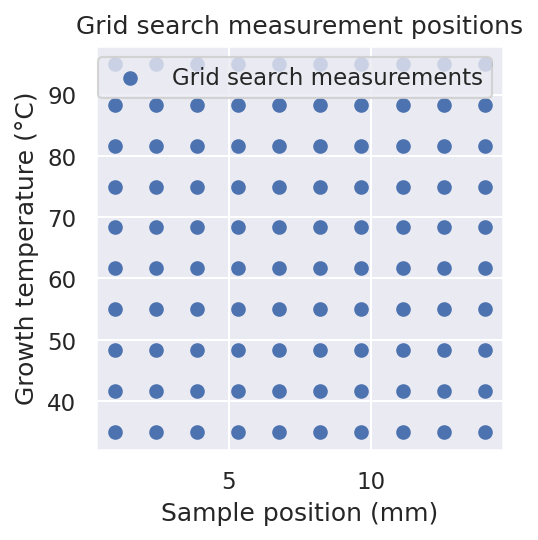

Grid search with 100 measurements results:
DNTT_A max with growth temperature: 11.67 °C and sample position: 76.67 mm
True DNTT_A max with growth temperature: 11.01 °C and sample position: 70.30 mm

Grid search with 100 measurements results:
DNTT_B max with growth temperature: 3.33 °C and sample position: 61.11 mm
True DNTT_B max with growth temperature: 4.56 °C and sample position: 59.70 mm

Grid search with 100 measurements results:
Liq max with growth temperature: 5.00 °C and sample position: 92.22 mm
True Liq max with growth temperature: 4.94 °C and sample position: 89.39 mm



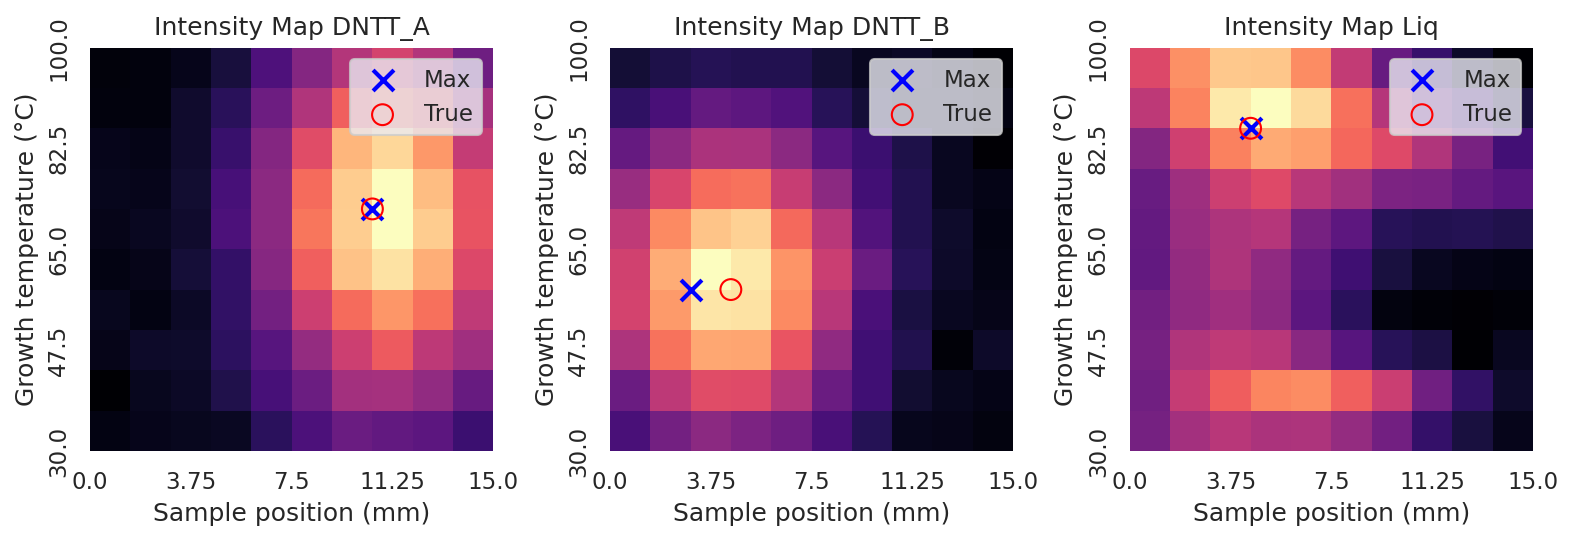

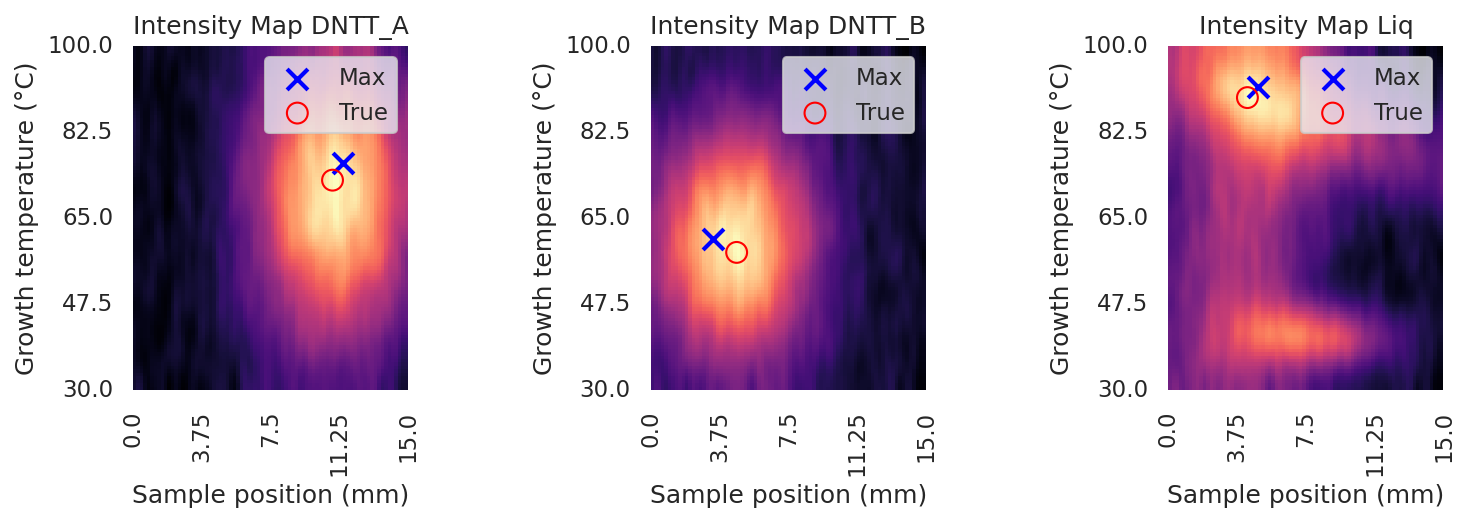

In [18]:

# Define the grid used to measure the intensity maps
n_measurements_xaxis, n_measurements_yaxis = 10, 10

measurement_grid = get_measurement_grid(x_min, x_max, y_min, y_max, x_npoints=n_measurements_xaxis, y_npoints=n_measurements_yaxis)

plot_measurement_grid(measurement_grid)

max_coords_grid_search_large = perform_grid_search_for_measurement_grid(noisy_distorted_maps, measurement_grid, n_measurements_xaxis, n_measurements_yaxis)


### B) Grid search on the smaller grid

Next, we perform a grid search on a smaller 7x7 grid for a total of 49 measurements. This setup allows us to compare the results with a denser grid and understand the impact of grid size on the identification of maximum intensities.

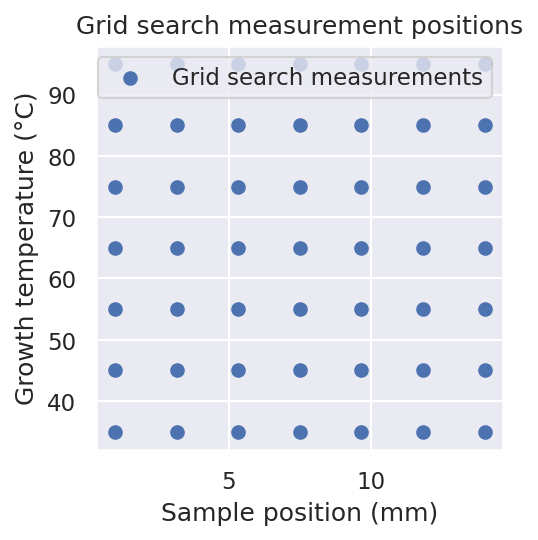

Grid search with 49 measurements results:
DNTT_A max with growth temperature: 12.50 °C and sample position: 76.67 mm
True DNTT_A max with growth temperature: 11.01 °C and sample position: 70.30 mm

Grid search with 49 measurements results:
DNTT_B max with growth temperature: 5.00 °C and sample position: 65.00 mm
True DNTT_B max with growth temperature: 4.56 °C and sample position: 59.70 mm

Grid search with 49 measurements results:
Liq max with growth temperature: 5.00 °C and sample position: 88.33 mm
True Liq max with growth temperature: 4.94 °C and sample position: 89.39 mm



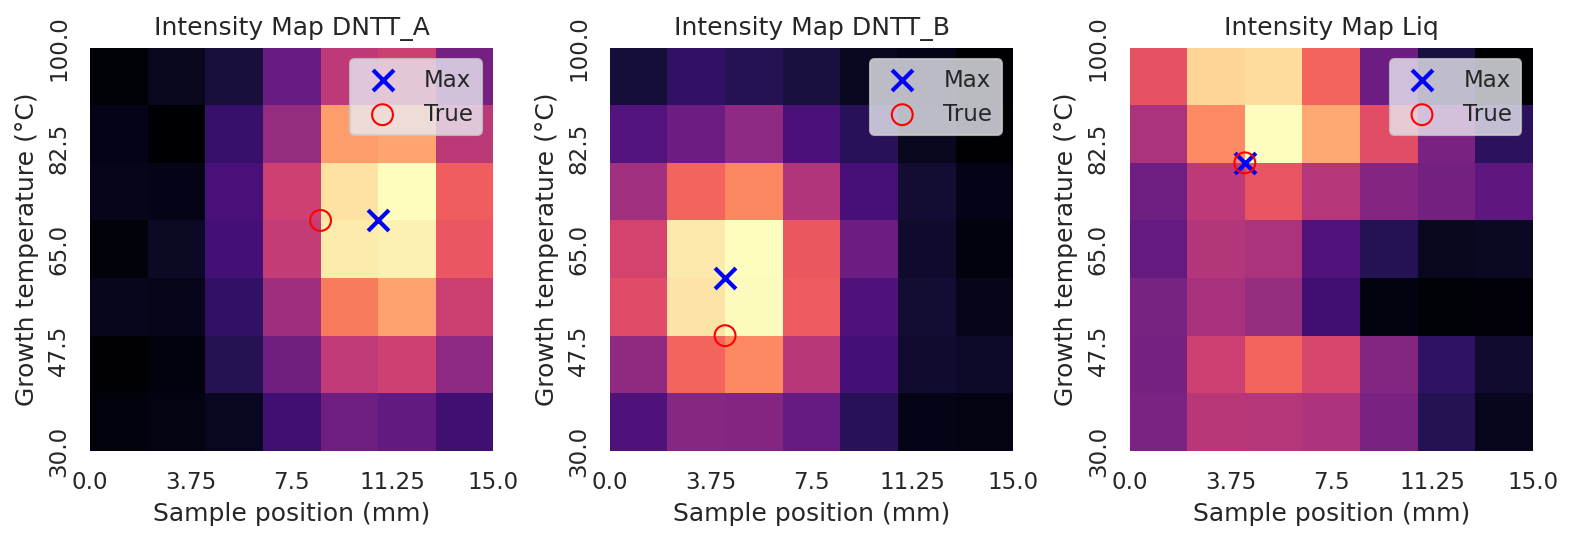

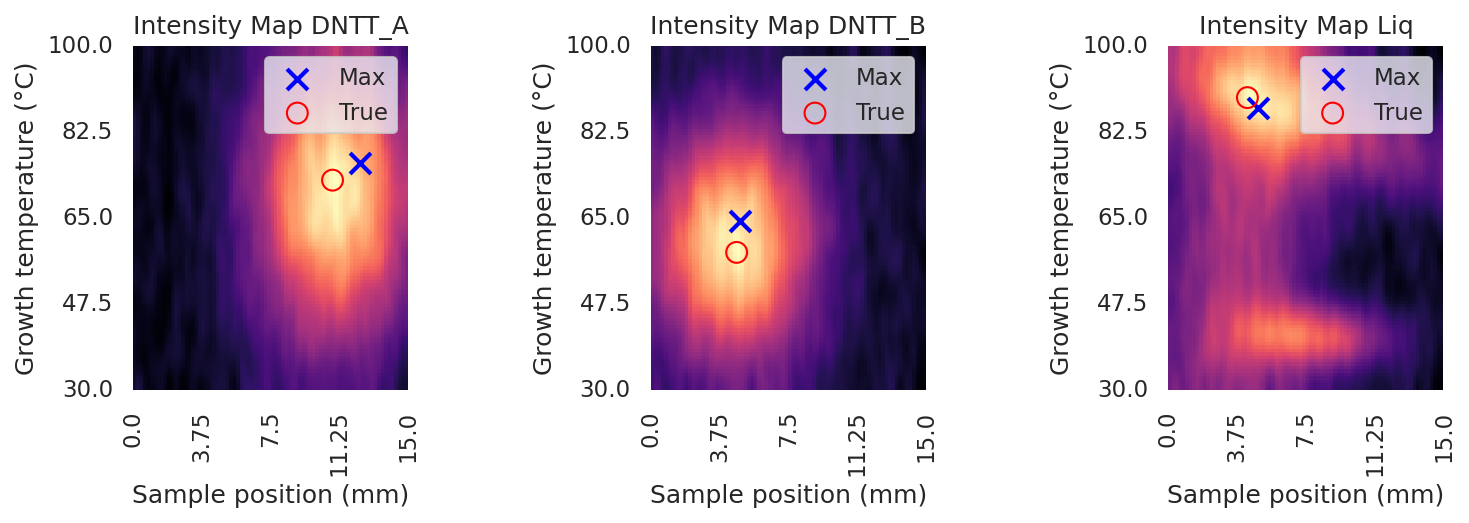

In [19]:
# Define the grid used to measure the intensity maps
n_measurements_xaxis, n_measurements_yaxis = 7, 7

measurement_grid = get_measurement_grid(x_min, x_max, y_min, y_max, x_npoints=n_measurements_xaxis, y_npoints=n_measurements_yaxis)

plot_measurement_grid(measurement_grid)

max_coords_grid_search_small = perform_grid_search_for_measurement_grid(noisy_distorted_maps, measurement_grid, n_measurements_xaxis, n_measurements_yaxis)

---
### 5. A detour into Stochastic Gradient Descent

In this section we explore Gradient Descent Optimization. Given the Given the assumption of some prior familiarity with Gradient Descent, we will not delve deeply into its theory and instead we'll on it's practical application in our context.

A key consideration in real-world scenarios, such as identifying coordinates for maximum feature intensities in X-ray diffraction patterns, is the discrete nature of the actual data points. This discreteness implies the absence of a continuous field for Gradient Descent to traverse in search of a global maxima.

However, within the realm of Gaussian Process-based Bayesian Optimization, Gradient Descent assumes an important role. By predicting a continuous field from previous measurements, the Gaussian Process enables the identification of maxima via Gradient Descent. Gradient Descent is then instrumental in proposing subsequent measurement points, and therefore it's important to understand the method’s limitations.

One notable limitation of Gradient Descent, particularly in fields with complex features, is its propensity to converge on local minima leading to suboptimal solutions. This characteristic introduces an element of stochasticity in our Bayesian Optimization.

In [20]:
# Functions to perform gradient descent optimization
#
####################################################################################################



def perform_gradient_descent(X0_points, bounds, intensity_maps, intensity_to_optimize_index=3):
    """
    Description:
    Algorithm to perform a gradient descent optimization on grid points in the intensity maps. Returns a DataFrame of the optimized coordinates and intensities labelled as x_coord, y_coord and intensity.
    The L-BFGS-B method is used for the optimization which is a quasi-Newton method that uses an approximation of the Hessian matrix.
    
    Inputs:
    X0_points (np.ndarray): 2D array of the initial measurement positions
    bounds (list): List of tuples of the bounds of the measurement grid
    intensity_maps (list): List of 2D arrays of the intensity maps
    intensity_to_optimize_index (int): Index of the intensity to be optimized
    
    Outputs:
    results (pd.DataFrame): DataFrame of the optimized coordinates and intensities of the three intensity maps.
    
    """
    
    # Get the bounds of the measurement grid
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]
    
    # Get the RBF interpolators for the intensity maps
    interpolators = get_RBF_interpolators(intensity_maps, bounds)
    
    results = []
    for initial_point in tqdm(X0_points):
        # Perform the gradient descent optimization

        result = minimize(gradient_descent_function_to_minimize, initial_point, method='L-BFGS-B', bounds=[(x_min, x_max), (y_min, y_max)],
                      args=(interpolators, intensity_to_optimize_index))
        
        # Flip the sign of result.fun to get the actual intensity
        x_coord, y_coord = result.x
        results.append((x_coord, y_coord,-result.fun))
    
    # Convert the list of results to a pandas DataFrame
    results = pd.DataFrame(results, columns=['x_coord', 'y_coord', 'intensity'])
    
    return results




def gradient_descent_function_to_minimize(x, interpolators, intensity_to_optimize_index):
    
    """
    Description:
    Function to minimize in the gradient descent optimization as minimization of the intensity is equivalent to maximization of the intensity.
    
    Inputs:
    x (tuple): Coordinate of the measurement, suggested by the optimizer
    interpolators (list): List of RBF interpolators for the intensity maps
    intensity_to_optimize_index (int): Index of the intensity to be optimized
    
    Outputs:
    - measured_intensity[intensity_to_optimize_index] (float): Negative intensity to be minimized
    
    """
    
    # Call the measurement function to get the measured intensity
    measured_intensity = get_measured_intensity(x, interpolators)
    
    # Return the negative intensity to perform maximization via minimization
    return - measured_intensity[intensity_to_optimize_index]



### A) Placement of initial points

Gradient descent requires some initial guesses of the intensity maximas are made. The following code sets up a grid of initial guesses, which are perturbed to avoid uniformity and simulate more realistic starting conditions.

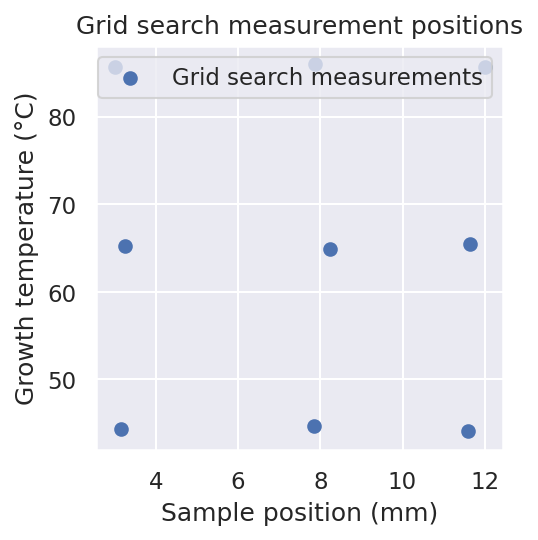

In [21]:
# Define the grid used to generate initial guesses for the gradient descent optimization
bounds = [(x_min, x_max), (y_min, y_max)]
X0_points = get_perturbed_grid(bounds = bounds, grid_size_x = 3, grid_size_y = 3, margin = 0.2, perturbation_scale = 0.33)


plot_measurement_grid(X0_points)


### B) Performing the gradient descent

Next the gradient descent optimization is performed. This process is applied to each of the distorted intensity maps – DNTT_A, DNTT_B, and Liq. The objective is to optimize the intensity for each map, starting from our previously defined initial guesses.

In [22]:
# Perform the gradient descent optimization on the distorted intensity maps, takes approx 10 seconds
DNTT_A_results = perform_gradient_descent(X0_points, bounds, [DNTT_A_map, DNTT_B_map, Liq_map], intensity_to_optimize_index=2)
DNTT_B_results = perform_gradient_descent(X0_points, bounds, [DNTT_A_map, DNTT_B_map, Liq_map], intensity_to_optimize_index=3)
liq_results = perform_gradient_descent(X0_points, bounds, [DNTT_A_map, DNTT_B_map, Liq_map], intensity_to_optimize_index=4)


100%|██████████| 9/9 [00:00<00:00, 44.82it/s]


### C) Calculating coordinates and plotting of gradient descent solutions

After completing the gradient descent, we extract and analyze the results. The coordinates that correspond to the maximum intensities for each optimization are identified. The points are then plotted on the intensity maps. Notably, some identified maximas are local and not global maximas, suggesting that when used to propose points to sample the gradient descent technique will not always identify the global maxima of the acquisition function.

Gradient descent results:
DNTT_A max with growth temperature: 11.14 °C and sample position: 65.36 mm
True DNTT_A max with growth temperature: 11.01 °C and sample position: 70.30 mm

Gradient descent results:
DNTT_B max with growth temperature: 4.75 °C and sample position: 55.47 mm
True DNTT_B max with growth temperature: 4.56 °C and sample position: 59.70 mm

Gradient descent results:
Liq max with growth temperature: 4.45 °C and sample position: 89.42 mm
True Liq max with growth temperature: 4.94 °C and sample position: 89.39 mm



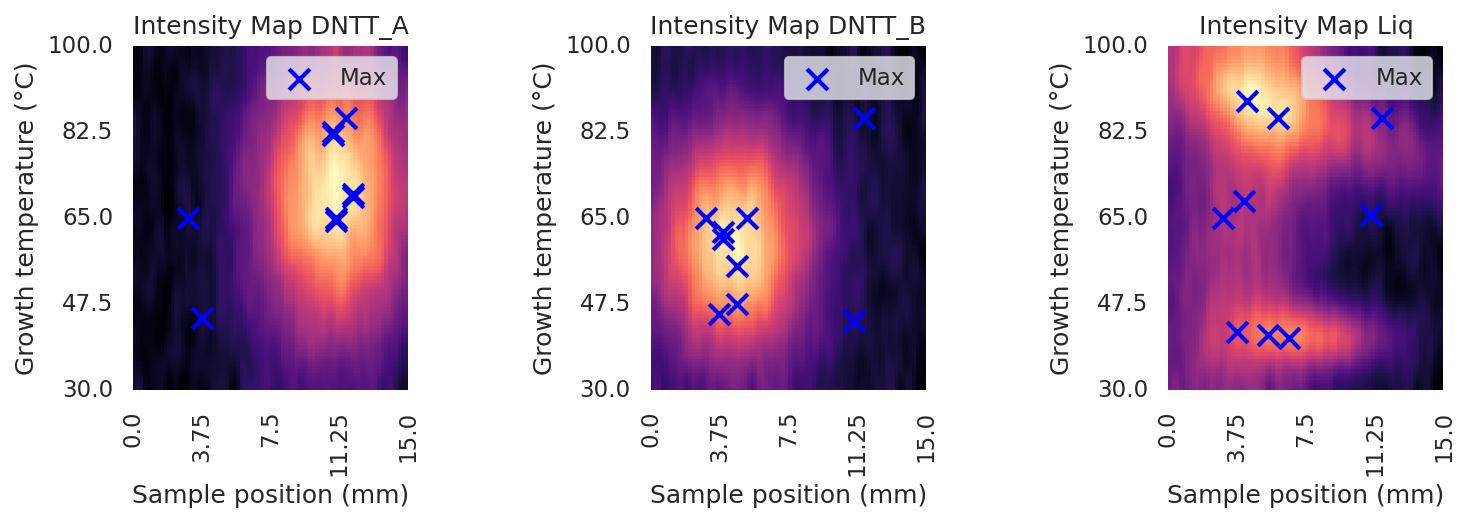

In [23]:
# Get the maximum index for each map and print the maxes
max_coords_gradient_descent_all, max_intensities_gradient_descent_all = zip(*[(np.dstack((results['x_coord'].values, results['y_coord'].values)).reshape(-1, 2), results['intensity'].values) for results in [DNTT_A_results, DNTT_B_results, liq_results]])

# Get the maximum intensity for each optimization and print the best of them for each map
max_coords_gradient_descent= []
max_indices_gradient_descent_all = []
for i, map_label in enumerate(labels):
    
    measured_max = max_coords_gradient_descent_all[i][np.argmax(max_intensities_gradient_descent_all[i])]
    print_maxes(measured_max, max_coords[i], map_label, 'Gradient descent')
    
    max_coords_gradient_descent.append(measured_max)
    max_indices_gradient_descent_all.append([(np.argmin(np.abs(x - measured_value[0])), np.argmin(np.abs(y - measured_value[1]))) for measured_value in max_coords_gradient_descent_all[i]])
    

# Get the indices of x and y that correspond to best maxes
max_indices_gradient_descent = [(np.argmin(np.abs(x - max_value[0])), np.argmin(np.abs(y - max_value[1]))) for max_value in max_coords_gradient_descent]


# Plot the gradient descent maps with all maxes to show that the optimization might get stuck in local maxima
plot_intensity_maps(noisy_distorted_maps, x, y, max_indices=max_indices_gradient_descent_all, labels=labels)

---
## 6.  Application of Gaussian Processes

In this chapter the theoretical theoretical concepts of Gaussian Processes (GPs) and Bayesian Optimization introduced in Chapter 2 are brought into practical application. Our primary objective is the efficient identification of intensity maxima in X-ray diffraction data, along with an examination of various exploration/exploitation strategies.

The implementation of Gaussian Processes employs RBF and bias kernels, initialized with six initial measurements. These measurements lead to the formation of two-dimensional fields representing the predicted mean, $\mu$, and uncertainty, $\sigma$, across the material's area. Setting the priors for the GP model isdone by informed estimation. In this case a fairly uniform prior for the lengthscale was initially used and refined to center around the final value obtained after the Bayesian Optimization. A generous choice of lengthscale bounds was made.

A critical adjustment in our approach is the inclusion of padding in the prediction grid. This padding allows the GP model to extrapolate predictions slightly beyond the actual measurement area in order to mitigate interpolation artifacts at the boundaries. To avoid sampling outside the material, optimization of the acquisition function is restricted to the actual field.

An important modification to the acquisition function is the incorporation of a boundary penalty. This adjustment mitigates a tendency of Gradient Descent to over-sample near the boundaries, which we assume are not the primary regions of interest.

The Bayesian Optimization algorithm is configured to test various predefined exploration/exploitation strategies. These strategies have been tuned through manual iteration for a Gaussian Process model initialized with six measurements set to expand with 15 additional measurements. Notably, the kappa value for the exploitative strategy is set intentionally low to show that overly exploitive strategies risk convergence to local maxima. The exploration strategy on the other hand demonstrates less sensitivity to high kappa values. 

The balanced strategy is calibrated to ensure that after 15 iterations, that is 21 total samples, the acquisition function retains characteristics of both the mean and uncertainty fields. The linear exploit strategy is designed to gradually decrease kappa, ensuring a relatively rapid convergence for 15 iterations. It's important to note that this strategy is not optimized for larger numbers of iterations, as increasing iterations also delays the transition to exploitative behavior.

Finally, we visualize the predictive grids derived from the GP models, showcasing the iterative convergence under different strategies. Note that the displayed mean, uncertainty, and acquisition function fields represent the final model state.

For a more in-depth discussion on the predicted intensity fields and the convergence rates of different strategies, please refer to Chapter 7, 'Comparison of Exploration/Exploitation Sampling Strategies.'

In [24]:
# Configuration of Bayesian optimization
#
####################################################################################################


def get_configuration(intensity_map_index, n_iter = 10, kappa_strategy = 'constant_exploit'):
    
    """
    Description:
    Function to get the configuration for Bayesian optimization.
    
    Inputs:
    intensity_map_index (int): Index of the intensity map to optimize
    n_iter (int): Number of iterations to perform
    kappa_strategy (str): Strategy to set kappa
    
    Outputs:
    n_iter (int): Number of iterations to perform
    kappa (float/list): Kappa parameter for the acquisition function
    lengthscale_bounds (tuple): Bounds of the lengthscale parameter
    lengthscale_prior_params (tuple): Parameters of the lengthscale prior
    
    """
    
    configurations = [
        {'lengthscale_bounds': (2, 15), 'lengthscale_prior_params': (5, 1)},
        {'lengthscale_bounds': (2, 15), 'lengthscale_prior_params': (5, 1)},
        {'lengthscale_bounds': (2, 15), 'lengthscale_prior_params': (5, 1)},
        ]
    
    # Set kappa to 1, balanced choice as standard
    kappa = 1
    
    if kappa_strategy == 'constant_exploit':
        kappa = 0.1
        
    elif kappa_strategy == 'constant_explore':
        kappa = 1000
        
    elif kappa_strategy == 'balanced':
        kappa = 1.5
        
    elif kappa_strategy == 'linear_exploit':
        # We have the option to change the initial kappa value depending on the number of iterations
        if n_iter > 20:
            kappa_min = 0.01
            kappa_max = 5
        else:
            kappa_min = 0.01
            kappa_max = 5
            
        kappa = np.linspace(kappa_min, kappa_max, n_iter)
        
        # Reverse the array so that the first iteration has the highest kappa
        kappa = kappa[::-1]
        
    return n_iter, kappa, configurations[intensity_map_index]['lengthscale_bounds'], configurations[intensity_map_index]['lengthscale_prior_params']



In [25]:
# Functions associated with the Gaussian Process model
#
####################################################################################################
       
          
def get_kernel(input_dim = 2, lengthscale_bounds = (2, 15), lengthscale_prior_params = (1, 1)):
    
    """
    Description:
    Function to generate a GPy kernel with a RBF kernel and a bias kernel.
    
    Inputs:
    input_dim (int): Number of input dimensions
    lengthscale_bounds (tuple): Bounds of the lengthscale parameter
    lengthscale_prior_params (tuple): Parameters of the lengthscale prior
    
    Outputs:
    kernel (GPy.kern): GPy kernel
    lengthscale_bounds (tuple): Bounds of the lengthscale parameter
    lengthscale_prior_params (tuple): Parameters of the lengthscale prior
    
    """
    
    k1 = GPy.kern.RBF(input_dim=input_dim)
    k1['lengthscale'].constrain_bounded(*lengthscale_bounds)
    
    a, b = lengthscale_prior_params
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=a, b=b))
    
    k2 = GPy.kern.Bias(input_dim=input_dim)
    return k1 + k2, lengthscale_bounds, lengthscale_prior_params



def get_model(x_data, y_data, kernel):
    """ 
    Description:
    Generate a GPy Gaussian Process model.
    
    Inputs:
    x_data (np.ndarray): 2D array of the x-data for measurement coordinates
    y_data (np.ndarray): 2D array of the y-data for measured intensities
    kernel (GPy.kern): GPy kernel
    
    Outputs:
    model (GPy.model): GPy Gaussian Process model
    
    """
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize_restarts(verbose=False, num_restarts=10)
    
    return model


# TODO Can we limit the size of updates? Fluctuates rather much.
def update_model(model, x_data, y_data, optimize_model = True):
    
    """
    Description:
    Update a GPy Gaussian Process model with new data.
    
    Inputs:
    model (GPy.model): GPy Gaussian Process model
    x_data (np.ndarray): 2D array of the x-data for measurement coordinates
    y_data (np.ndarray): 2D array of the y-data for measured intensities
    optimize_model (bool): Whether to optimize the model after updating
    
    Outputs:
    model (GPy.model): GPy Gaussian Process model
    
    """
    
    model.set_XY(x_data, y_data)
    
    if optimize_model:
        model.optimize_restarts(verbose=False, num_restarts=10)
    
    return model



def acquisition_function(x, model, kappa):
    """
    Description:
    Function to calculate the acquisition function from the predicted mean and variance of the Gaussian Process model and a linear penalty for points close to the boundary.
    
    Inputs:
    x (np.ndarray): 1D array of the measurement coordinates
    model (GPy.model): GPy Gaussian Process model
    kappa (float): Kappa parameter for the acquisition function
    
    Outputs:
    acquisition_value (float): Acquisition value
    
    """
    
    mu, sigma2 = model.predict(x.reshape(1, -1))
    mu, sigma2 = mu[0, 0], sigma2[0, 0]
    
    acquisition_value = mu + kappa * np.sqrt(sigma2)
    
    penalty = get_single_coordinate_boundary_penalty(x, bounds)
    
    return acquisition_value - penalty



def acquisition_function_to_minimize(x, model, kappa):
    """
    Description:
    Function to minimize in the gradient descent optimization of the acquisition function.
    
    Inputs:
    x (np.ndarray): 1D array of the measurement coordinates
    model (GPy.model): GPy Gaussian Process model
    kappa (float): Kappa parameter for the acquisition function
    
    Outputs:
    - acquisition_function(x, model, kappa) (float): Negative acquisition value to be minimized
    
    """
    
    return - acquisition_function(x, model, kappa)


def get_GP_grid_properties(grid, model, kappa, penalty_grid):
    
    """
    Description:
    Function to calculate the mean, standard deviation and acquisition value (with linear penalty) for a grid of coordinates using a Gaussian Process model.
    
    Inputs:
    grid (np.ndarray): 2D array of the measurement coordinates
    model (GPy.model): GPy Gaussian Process model
    kappa (float): Kappa parameter for the acquisition function
    
    Outputs:
    mean (np.ndarray): 1D array of the predicted mean
    std (np.ndarray): 1D array of the predicted standard deviation
    acquisition_values (np.ndarray): 1D array of the acquisition values
    
    """
    
    mean, variance = model.predict(grid.reshape(-1, 2))
    std = np.sqrt(variance)
    
    if isinstance(kappa, (list, np.ndarray)):
            kappa = kappa[-1]
            
    acquisition_values = mean + kappa * std
    
    return mean, std, acquisition_values - penalty_grid


def get_GP_max_coordinates(mean, prediction_grid):
    
    """
    Description:
    Function to get the maximum coordinates from the predicted mean of a Gaussian Process model.
    
    Inputs:
    mean (np.ndarray): 1D array of the predicted mean
    prediction_grid (np.ndarray): 2D array of the measurement coordinates
    
    Outputs:
    max_index (int): Index of the maximum value
    max_coords (tuple): Tuple of the maximum coordinates
    
    """

    max_index = np.argmax(mean)
    max_coords = prediction_grid[max_index]
    
    return max_index, max_coords



def convert_prediction_map_to_intensity_map(prediction_map, prediction_grid, x, y):
    
    """
    Description:
    Function to convert a prediction map to an intensity map.
    
    Inputs:
    prediction_map (np.ndarray): 1D array of the prediction map
    prediction_grid (np.ndarray): 2D array of the measurement coordinates
    x (np.ndarray): 1D array of the x-coordinates
    y (np.ndarray): 1D array of the y-coordinates
    
    Outputs:
    prediction_map_interpolated (np.ndarray): 2D array of the interpolated prediction map
    
    """

    X_new, Y_new = np.meshgrid(x, y)
    
    points = prediction_grid 
    values = prediction_map.flatten() 

    prediction_map_interpolated = griddata(points, values, (X_new, Y_new), method='cubic')

    return prediction_map_interpolated


def get_single_coordinate_boundary_penalty(x, bounds, penalty_scale=0.1):
    """
    Description:
    Function to calculate a linear penalty for a single point close to the boundary.

    Inputs:
    x (np.ndarray): 1D array of the measurement coordinates
    bounds (list): List of tuples of the bounds of the measurement grid
    penalty_scale (float): Penalty scale, the higher the value, the stronger the penalty

    Outputs:
    penalty (float): Penalty value

    """
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    # Calculate the normalized distance to the nearest boundary for each dimension
    x_distance = min(abs(x[0] - x_min), abs(x[0] - x_max)) / (x_max - x_min)
    y_distance = min(abs(x[1] - y_min), abs(x[1] - y_max)) / (y_max - y_min)
    
    # Calculate the penalty for being close to the boundary
    penalty = penalty_scale * (1 - x_distance) + penalty_scale * (1 - y_distance)

    return penalty


def boundary_penalty(x, bounds, penalty_scale=0.1):
    """
    Description:
    Function to calculate a linear penalty for points close to any boundary (x_min, x_max, y_min, y_max).

    Inputs:
    x (np.ndarray): 1D array of the measurement coordinates
    bounds (list): List of tuples of the bounds of the measurement grid
    penalty_scale (float): Penalty scale, the higher the value, the stronger the penalty

    Outputs:
    penalty (float): Penalty value

    """
    x_min, x_max = bounds[0]
    y_min, y_max = bounds[1]

    # Normalize distances by the range of each dimension
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calculate the normalized distance to the nearest boundary for each dimension
    distances_normalized = np.array([
        np.min([np.abs((x[0] - x_min) / x_range), np.abs((x[0] - x_max) / x_range)]),
        np.min([np.abs((x[1] - y_min) / y_range), np.abs((x[1] - y_max) / y_range)])
    ])

    # Adjust the penalty to be more balanced and prevent it from becoming too large
    boundary_penalty_grid = penalty_scale * np.sum(np.maximum(1 - distances_normalized, 0))

    return boundary_penalty_grid


In [26]:
# Function that performs the gradient descent optimization of the acquisition function
#
####################################################################################################


def get_next_point(model, kappa, bounds, epsilon_x = 1, epsilon_y = 5):
    
    """
    Description:
    Function to get the next point to measure by using gradient descent on the acquisition function.
    
    Inputs:
    model (GPy.model): GPy Gaussian Process model
    kappa (float): Kappa parameter for the acquisition function
    bounds (list): List of tuples of the bounds of the measurement grid
    
    
    Outputs:
    best_X (np.ndarray): 1D array of the best measurement coordinates
    
    """
    # Initialize the best point and acquisition value to be very low
    best_X = None
    best_acquisition_value = -np.inf
    
    # Get the initial guesses for the gradient descent optimization of the acquisition function
    X0_points = get_perturbed_grid(bounds = bounds, grid_size_x = 4, grid_size_y = 4, margin = 0.2, perturbation_scale = 0.1)

    bounds_retracted = [(bounds[0][0] + epsilon_x, bounds[0][1] - epsilon_x), (bounds[1][0] + epsilon_y, bounds[1][1] - epsilon_y)]

    # Perform the gradient descent optimization of the acquisition function
    for x0 in X0_points:
        
        result = minimize(acquisition_function_to_minimize, x0, args=(model, kappa), bounds=bounds_retracted)
        if -result.fun > best_acquisition_value:
            best_acquisition_value = -result.fun
            best_X = result.x
            
    if best_X is None:
        for x0 in get_perturbed_grid(bounds = bounds, grid_size_x = 4, grid_size_y = 4, margin = 0.1, perturbation_scale = 0.1):
            result = minimize(acquisition_function_to_minimize, x0, args=(model, kappa), bounds=bounds)
            if -result.fun > best_acquisition_value:
                best_acquisition_value = -result.fun
                best_X = result.x
        
    return best_X

In [27]:
# Functions to plot and print the Bayesian optimization results
#
####################################################################################################

def plot_GP(mean, std, acquisition_values, prediction_grid, sampled_points, best_X, best_y, n_initial_points, x_npoints=20, y_npoints=20):
    
    """
    Description:
    Function to plot the Gaussian Process model predictions.
    
    Inputs:
    mean (np.ndarray): 1D array of the predicted mean
    std (np.ndarray): 1D array of the predicted standard deviation
    acquisition_values (np.ndarray): 1D array of the acquisition values
    prediction_grid (np.ndarray): 2D array of the measurement coordinates
    sampled_points (np.ndarray): 2D array of the sampled measurement coordinates
    best_X (np.ndarray): 1D array of the best measurement coordinates
    best_y (float): Best intensity
    n_initial_points (int): Number of initial points
    
    Outputs:
    None
    
    """
    
    fig, ax = plt.subplots(1, 3, figsize=(3*3.5, 3.5))

    # Assuming x_points and y_points are the coordinates used to create prediction_grid
    x_points = prediction_grid[:, 0].reshape(x_npoints, y_npoints).mean(axis=0)
    y_points = prediction_grid[:, 1].reshape(x_npoints, y_npoints).mean(axis=1)
    
    # Reshape the 1D arrays into 2D arrays for contour plotting
    mean_2d = mean.reshape(len(y_points), len(x_points))
    std_2d = std.reshape(len(y_points), len(x_points))
    acquisition_2d = acquisition_values.reshape(len(y_points), len(x_points))

    
    grid_properties = [(mean_2d, 'Mean', 'Intensity [arb. u.]'),
                       (std_2d, 'Standard deviation', 'Intensity [arb. u.]'),
                       (acquisition_2d, 'Acquisition function', 'Acquisition value')]

    initial_points = sampled_points[:n_initial_points]
    sampled_points = sampled_points[n_initial_points:]
    
    for idx, (grid_property, title, ylabel) in enumerate(grid_properties):
        
        contour = ax[idx].contourf(x_points, y_points, grid_property, levels=50, cmap='magma')
        ax[idx].set_xlabel('Sample position (mm)')
        ax[idx].set_ylabel('Growth temperature (°C)')
        ax[idx].set_title(title)
        
        colorbar = fig.colorbar(contour, ax=ax[idx], format='%.2f')
        colorbar.set_label(ylabel)
        
        # Scatter the sampled points
        ax[idx].scatter(initial_points[:, 0], initial_points[:, 1], marker='x', color='red', s=50)
        
        # Set the colormap to show the iteration number
        cmap_iterations = "Blues_r"
        color = np.arange(len(sampled_points))
        scattered = ax[idx].scatter(sampled_points[:, 0], sampled_points[:, 1], marker='x', c=color, cmap=cmap_iterations, s=50)
        
        ax[idx].scatter(best_X[0], best_X[1], marker='o', color='white', s=100, label='Best point')
        
    plt.tight_layout()
    plt.show()
    
    

def verify_model(intensity_maps, model, intensity_map_index, lengthscale_bounds, lengthscale_prior_params):
    """
    Description:
    Function to print the Gaussian Process model predictions.
    
    Inputs:
    intensity_maps (list): List of 2D arrays of the intensity maps
    model (GPy.model): GPy Gaussian Process model
    intensity_map_index (int): Index of the intensity map to verify
    lengthscale_bounds (tuple): Bounds of the lengthscale parameter
    lengthscale_prior_params (tuple): Parameters of the lengthscale prior
    
    Outputs:
    None
    
    """
    print(model, '\n')
    
    print(f'Intensity map mean: {intensity_maps[intensity_map_index].mean():.2f}, model bias variance: {model.kern.bias.variance[0]:.2f}')
    
    print(f'Intensity map variance: {intensity_maps[intensity_map_index].var():.2f}, model RBF variance: {model.kern.rbf.variance[0]:.2f}')
    
    print(f'Lengthscale bounds: {lengthscale_bounds}, model lengthscale: {model.kern.rbf.lengthscale[0]:.2f}')

In [28]:
# Algorithm to perform Bayesian optimization (Importance sampling)
#
####################################################################################################


def bayesian_optimization(interpolators, prediction_grid, true_maxima, bounds, X0_points, n_iter, kappa, intensity_to_optimize_index = 3, optimize_final_model = True, lengthscale_bounds = (0.1, 20), lengthscale_prior_params = (1, 1)):
    
    """
    Description:
    Algorithm to perform Bayesian optimization (Importance Sampling) on grid points in the intensity maps using a Gaussian Process.
    
    Inputs:
    interpolators (list): List of RBF interpolators for the intensity maps
    bounds (list): List of tuples of the bounds of the measurement grid
    X0_points (np.ndarray): 2D array of the initial measurement positions
    n_iter (int): Number of iterations to perform
    kappa (float/list): Kappa parameter for the acquisition function, balancing exploration and exploitation
    intensity_to_optimize_index (int): Index of the intensity to be optimized
    optimize_final_model (bool): Whether to optimize the final model
    lengthscale_bounds (tuple): Bounds of the lengthscale parameter
    lengthscale_prior_params (tuple): Parameters of the lengthscale prior
    
    Outputs:
    x_data (np.ndarray): 2D array of the measurement coordinates
    best_X (np.ndarray): 1D array of the best measurement coordinates
    best_y (float): Best intensity
    model (GPy.model): GPy Gaussian Process model
    
    """
    
    # Get the x and y-data for the initial measurements and use them to initialize the Gaussian Process model
    x_data = X0_points
    
    measured_intensities = [get_measured_intensity(x, interpolators) for x in x_data]
    y_data = np.array(measured_intensities)[:, intensity_to_optimize_index].reshape(-1, 1)
    
    kernel, lengthscale_bounds, lengthscale_prior_params = get_kernel(lengthscale_bounds = lengthscale_bounds, lengthscale_prior_params = lengthscale_prior_params)
    model = get_model(x_data, y_data, kernel)
    
    # If kappa is a list, use the list to update kappa for each iteration
    kappa_input = kappa
    
    if isinstance(kappa_input, (list, np.ndarray)):
            kappa = kappa_input[0]
       
    boundary_penalty_grid = np.array([boundary_penalty(coord, bounds) for coord in prediction_grid.reshape(-1, 2)]).reshape(-1,1)
    
    mean, std, acquisition_values = get_GP_grid_properties(prediction_grid, model, kappa, boundary_penalty_grid)
    
    _, mean_max_coords = get_GP_max_coordinates(mean, prediction_grid)
    
    # Calculate distances for current strategy and map
    distances_to_true_maxima = np.linalg.norm(np.array(mean_max_coords) - np.array(true_maxima))
    
    # Perform the Bayesian optimization
    for i in tqdm(range(n_iter)):
        
        # If kappa is a list, use the list to update kappa for each iteration
        if isinstance(kappa_input, (list, np.ndarray)):
            kappa = kappa_input[i]
        
        # Get the next point to measure by using gradient descent on the acquisition function
        next_X = get_next_point(model, kappa, bounds)
        
        # Measure the intensity at the next point
        next_y = get_measured_intensity(next_X, interpolators)[intensity_to_optimize_index]
        
        # Update the model with the new data
        x_data = np.vstack((x_data, next_X))
        y_data = np.vstack((y_data, next_y))
        
        model = update_model(model, x_data, y_data, optimize_model = True) # While sampling many points, one can choose to optimize the model in intermediate steps
        
        mean, std, acquisition_values = get_GP_grid_properties(prediction_grid, model, kappa, boundary_penalty_grid)
        
        _, mean_max_coords = get_GP_max_coordinates(mean, prediction_grid)
        
        distance_to_maxima = np.linalg.norm(np.array(mean_max_coords) - np.array(true_maxima))
        
        distances_to_true_maxima = np.vstack((distances_to_true_maxima, distance_to_maxima))
        
    # Get the best measurement coordinates and intensity
    best_X = mean_max_coords
    best_y = get_measured_intensity(best_X, interpolators)[intensity_to_optimize_index]

    return x_data, best_X, best_y, distances_to_true_maxima, model



In [29]:
# Algorithm to loop through the three intensity maps and perform Bayesian optimization
#
####################################################################################################

def loop_through_maps(interpolators, prediction_grid, x_npoints, y_npoints, DNTT_A_index, DNTT_B_index, Liq_index, n_iter, n_initial_points, max_coords = max_coords, kappa_strategy = 'balanced', plotting = True, bounds = bounds, X0_points = X0_points):
    
    """
    Description:
    Function to loop through the three intensity maps and perform Bayesian optimization.
    
    Inputs:
    interpolators (list): List of RBF interpolators for the intensity maps
    DNTT_A_index (int): Index of the DNTT_A map
    DNTT_B_index (int): Index of the DNTT_B map
    Liq_index (int): Index of the Liq map
    n_iter (int): Number of iterations to perform
    n_initial_points (int): Number of initial points
    kappa_strategy (str): Strategy to set kappa
    
    Outputs:
    predicted_mean_maps (list): List of 2D arrays of the predicted mean
    sampled_points_per_map (list): List of 2D arrays of the sampled measurement coordinates
    
    """
    
    predicted_mean_maps = []
    sampled_points_per_map = []
    distances_to_true_maxima_per_map = []
    for intensity_to_optimize_index in [DNTT_A_index, DNTT_B_index, Liq_index]:
        intensity_map_index = intensity_to_optimize_index - 2
        
        n_iter, kappa, lengthscale_bounds, lengthscale_prior_params = get_configuration(intensity_map_index, n_iter = n_iter, kappa_strategy = kappa_strategy)
        
        true_maxima = max_coords[intensity_to_optimize_index - 2] # The index of the map in the true_maxima list]
        
        sampled_points, best_X, best_y, distances_to_true_maxima, model = bayesian_optimization(interpolators, prediction_grid, true_maxima, bounds, X0_points, n_iter = n_iter, kappa = kappa, intensity_to_optimize_index = intensity_to_optimize_index, optimize_final_model = True, lengthscale_bounds = lengthscale_bounds, lengthscale_prior_params = lengthscale_prior_params)

        #verify_model([DNTT_A_map, DNTT_B_map, Liq_map], model, intensity_map_index, lengthscale_bounds, lengthscale_prior_params)

        boundary_penalty_grid = np.array([boundary_penalty(coord, bounds) for coord in prediction_grid.reshape(-1, 2)]).reshape(-1,1)
        mean, std, acquisition_values = get_GP_grid_properties(prediction_grid, model, kappa, boundary_penalty_grid)
        
        predicted_mean_maps.append(mean)
        sampled_points_per_map.append(sampled_points)
        distances_to_true_maxima_per_map.append(distances_to_true_maxima)
        
        
        if plotting:
            plot_GP(mean, std, acquisition_values, prediction_grid, sampled_points, best_X, best_y, n_initial_points, x_npoints = x_npoints, y_npoints=y_npoints)
    
    return predicted_mean_maps, sampled_points_per_map, distances_to_true_maxima_per_map



### A)  Initialization of Bayesian Optimization

We start by generating 6 initial points for the optimization process, perturbed to ensure a diverse starting landscape. Then Radial Basis Function (RBF)  are created as interpolators for our intensity maps. We also set the number of iterations for optimization. The indices corresponding to the different intensity maps are clarified to avoid confusion as indices 0 and 1 in measurement results correspond to the measured x and y-coordinates.

In [30]:
X0_points = get_perturbed_grid(bounds = bounds, grid_size_x = 2, grid_size_y = 3, margin = 0.02, perturbation_scale = 0., random_seed = 42)

n_initial_points = len(X0_points)

# Get the RBF interpolators for the intensity maps, takes approx 8 seconds
rbf_interpolators = get_RBF_interpolators([DNTT_A_map, DNTT_B_map, Liq_map], bounds)

# Column indices of the measurement results corresponding to the respective intensity maps
DNTT_A_index = 2
DNTT_B_index = 3
Liq_index = 4

# Set the number of iterations and initial points for the Bayesian optimization
n_iter = 10

x_npoints = 20
y_npoints = 20

prediction_grid = get_measurement_grid(x_min, x_max, y_min, y_max, x_npoints=x_npoints, y_npoints=y_npoints, epsilon_x=-1, epsilon_y=-5) # Get a padded grid to get the prediction map

### B) Looping through with different strategies

We proceed to apply the Bayesian Optimization algorithm across our intensity maps using four distinct kappa strategies; 'balanced', 'constant_exploit', 'linear_exploit', and 'constant_explore', where each strategy represents a different balance between exploration and exploitation. 

The optimization is executed for each strategy for a fixed number of iterations. The optimization path and the proximity of the identified maxima to the the noisy "true" maxima are recorded during the optimizations. These sampled coordinates and maxima proximites are saved and discussed in chapter 7. 

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


Kappa strategy: balanced


100%|██████████| 15/15 [00:54<00:00,  3.66s/it]


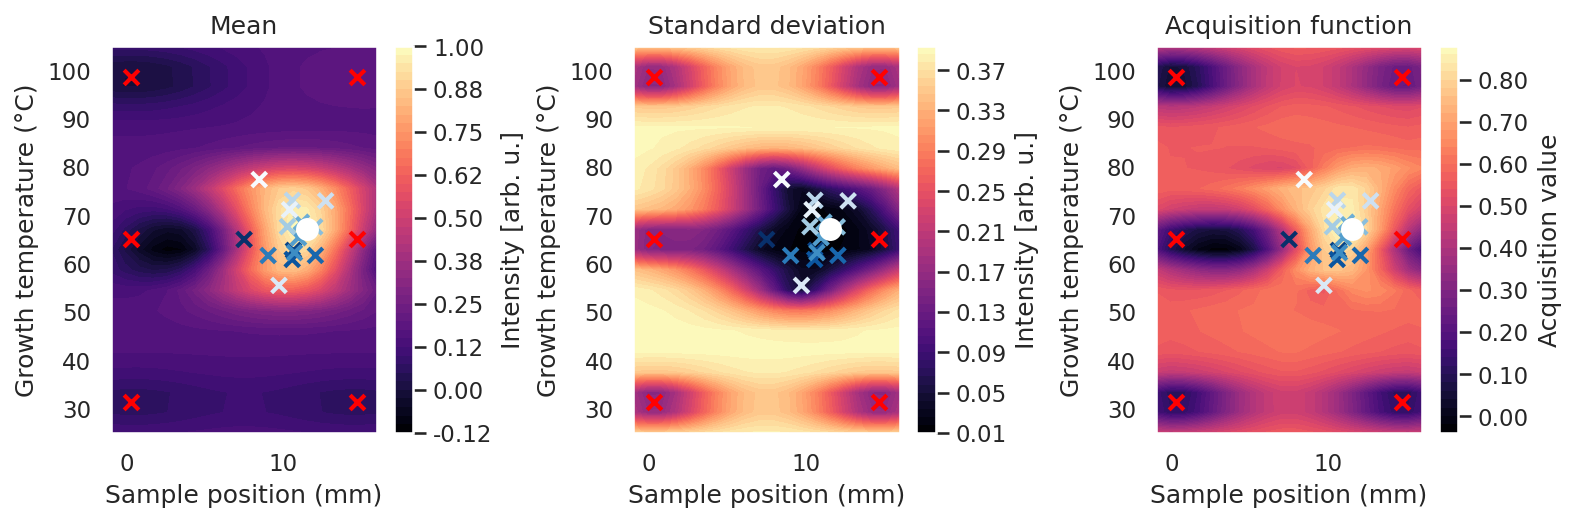

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [01:06<00:00,  4.40s/it]


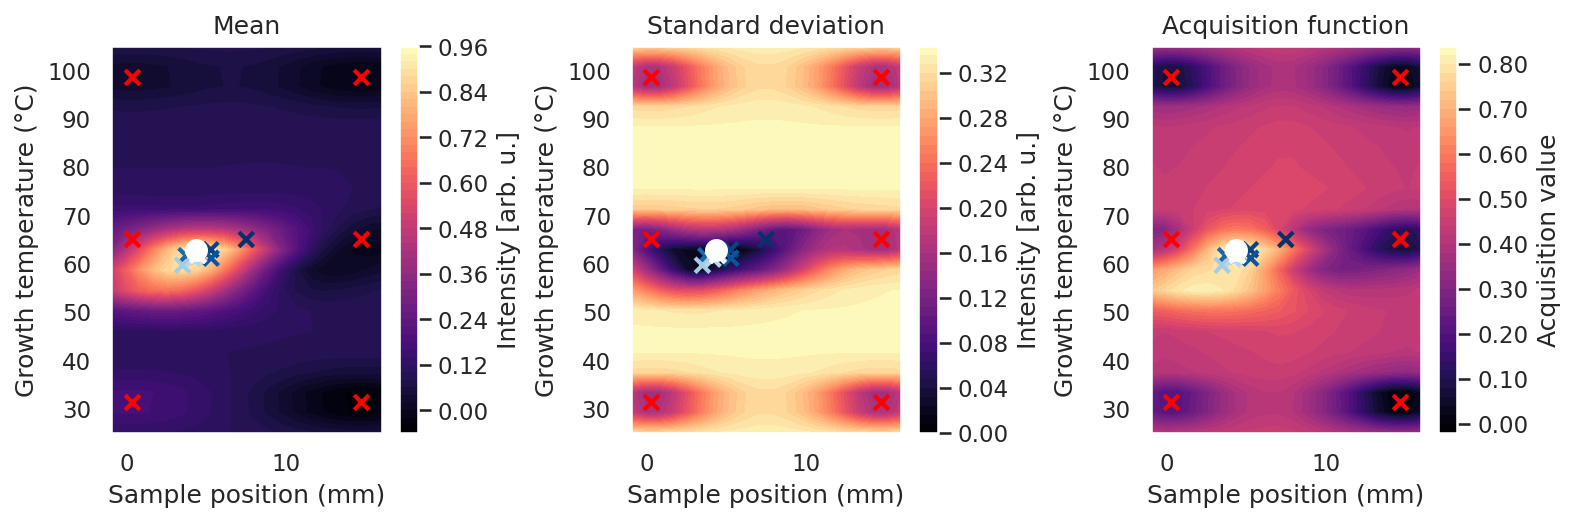

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [01:07<00:00,  4.51s/it]


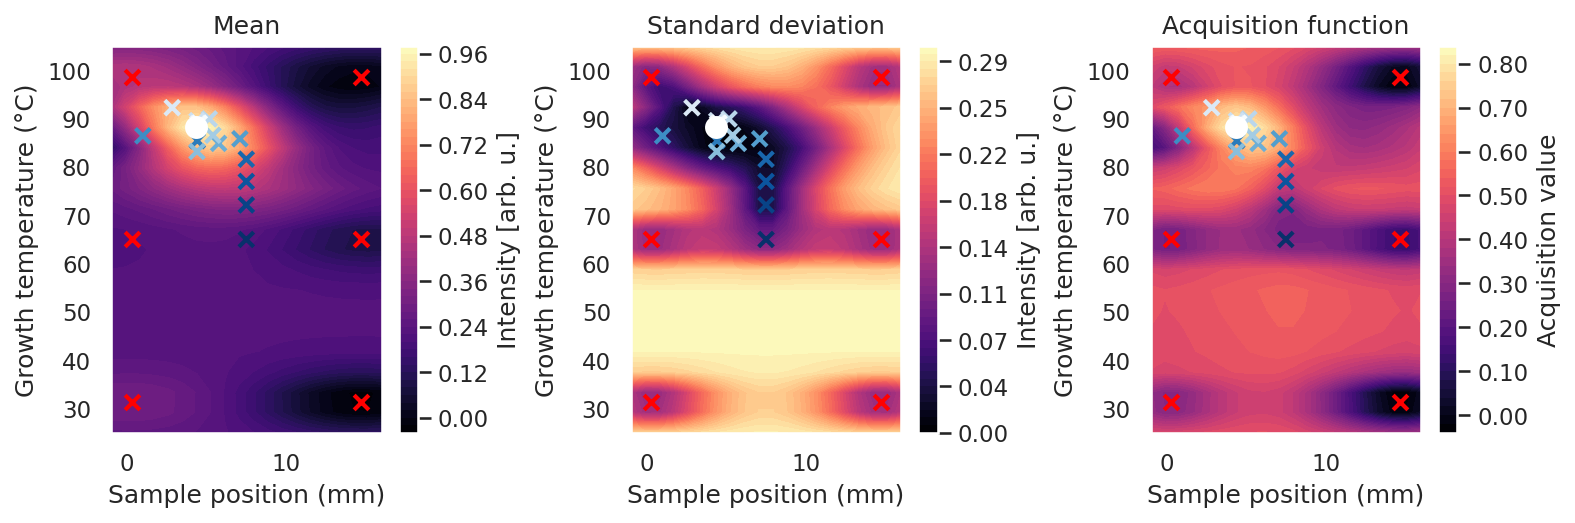

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


Kappa strategy: linear_exploit


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


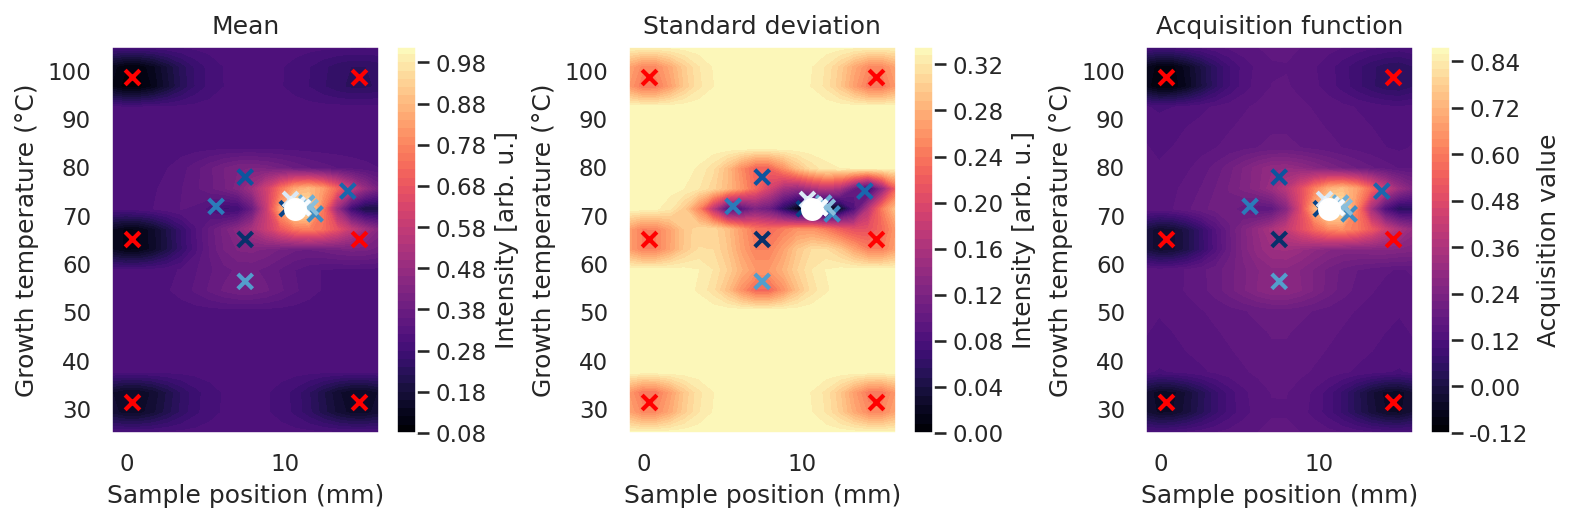

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:42<00:00,  2.85s/it]


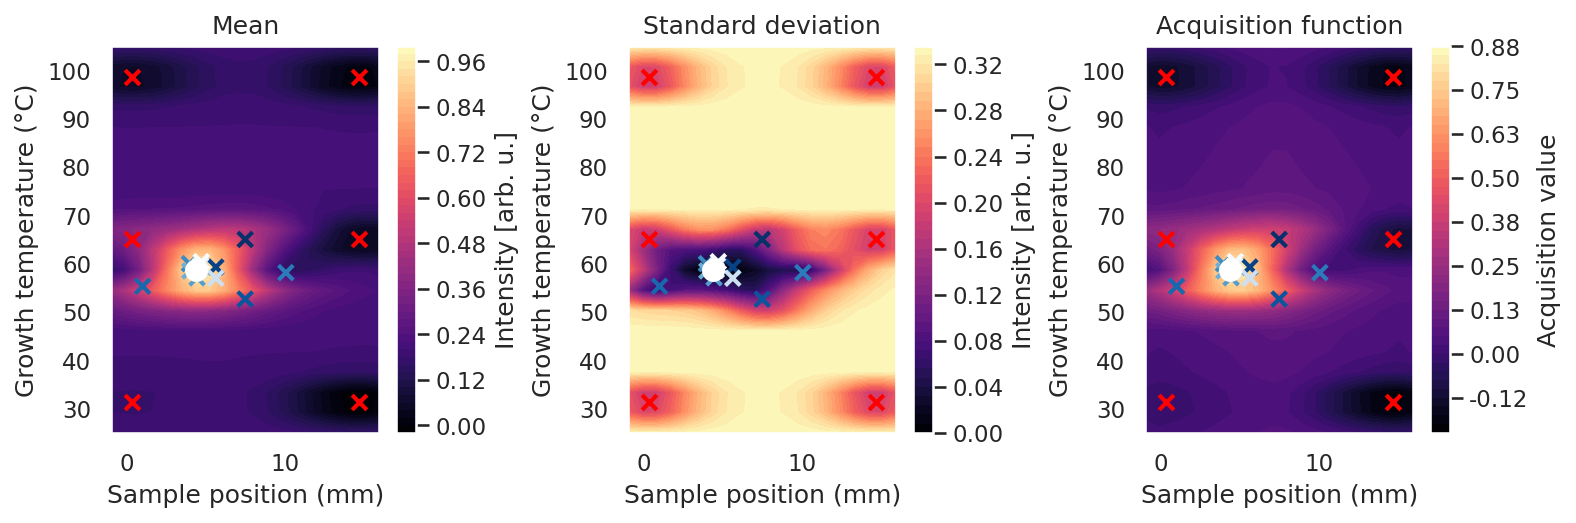

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


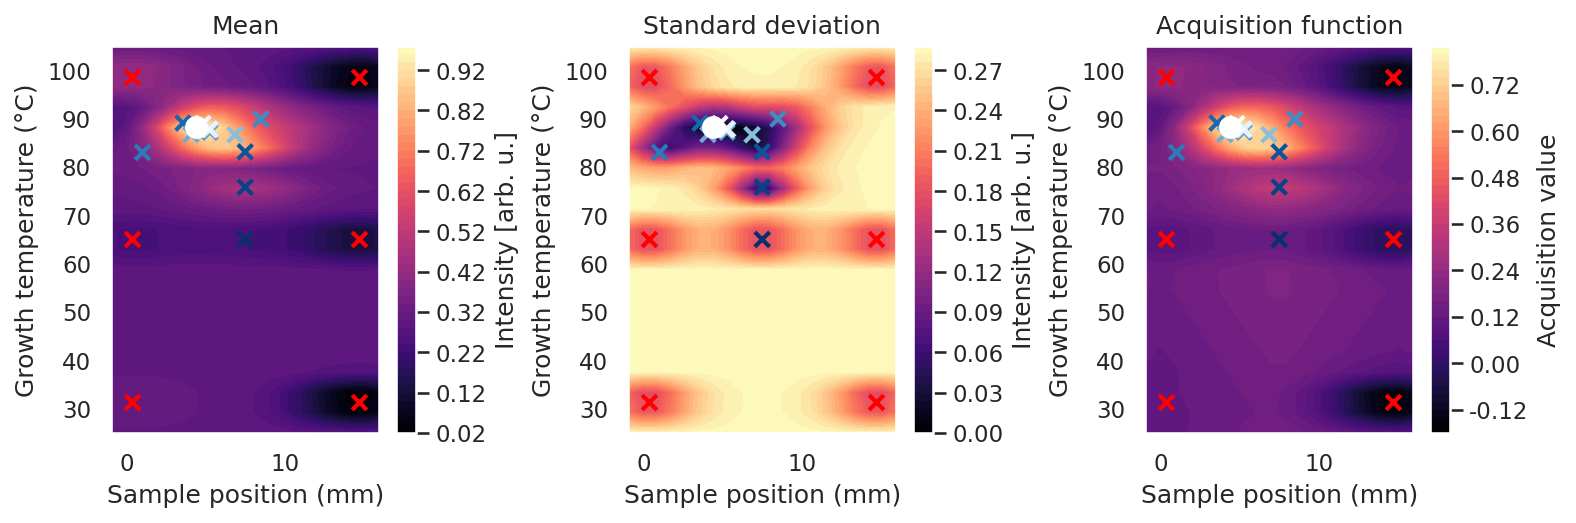

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


Kappa strategy: constant_exploit


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


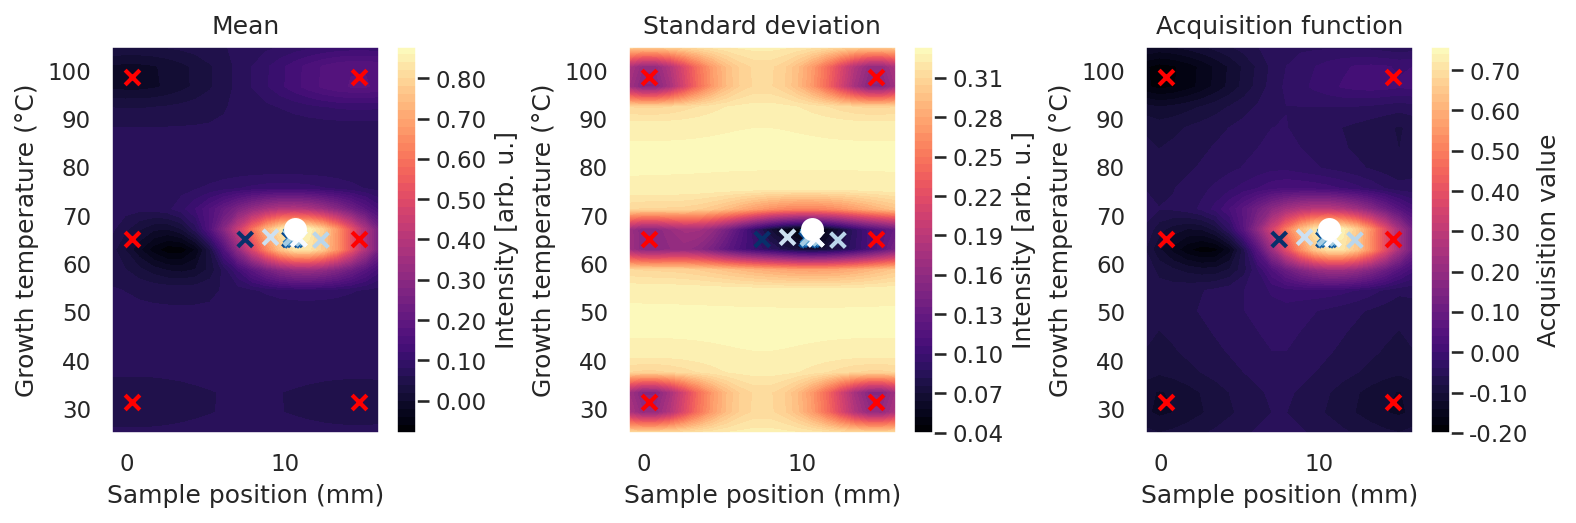

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


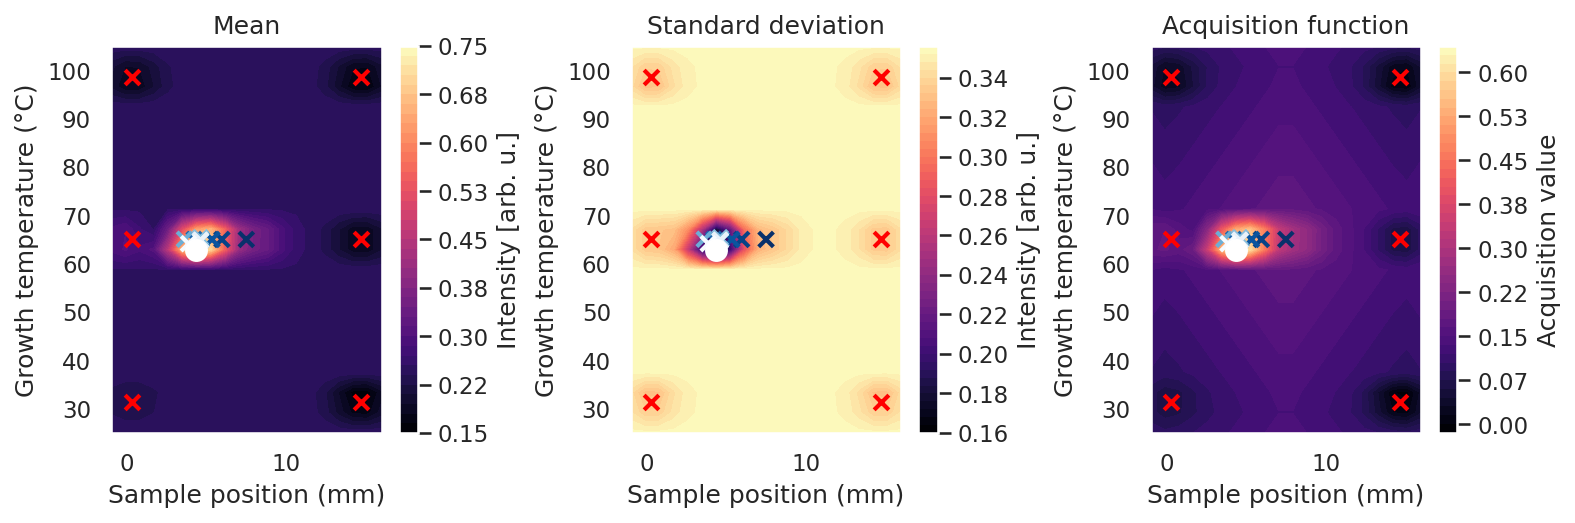

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


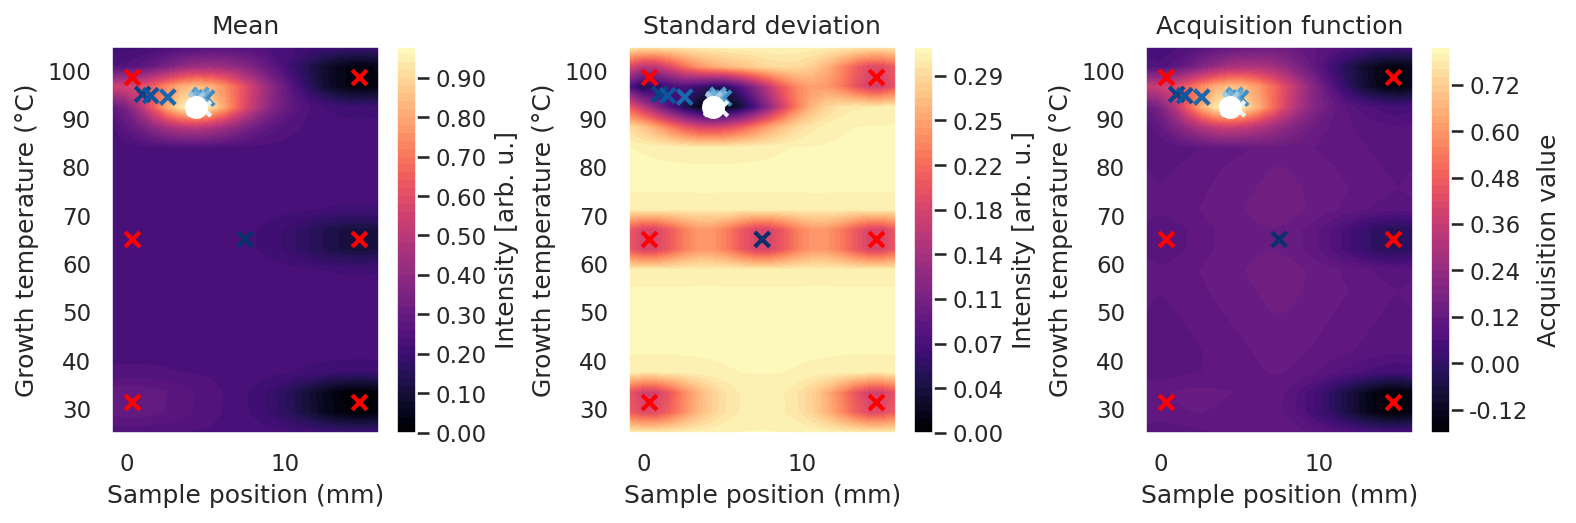

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


Kappa strategy: constant_explore


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


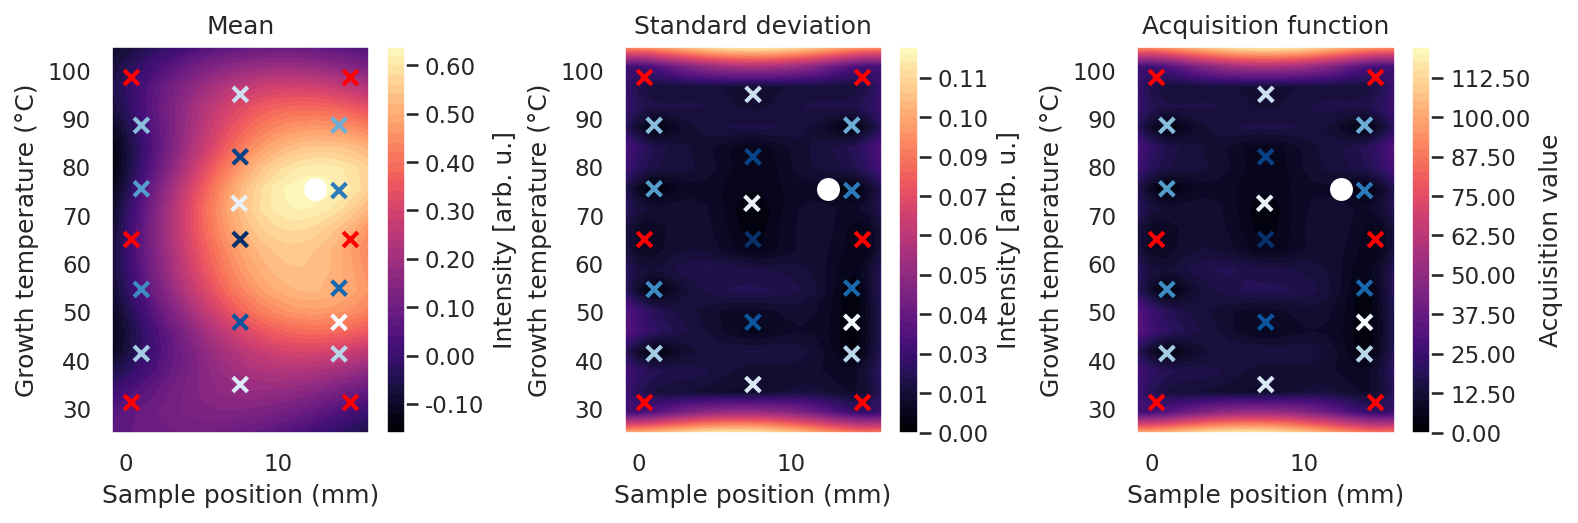

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


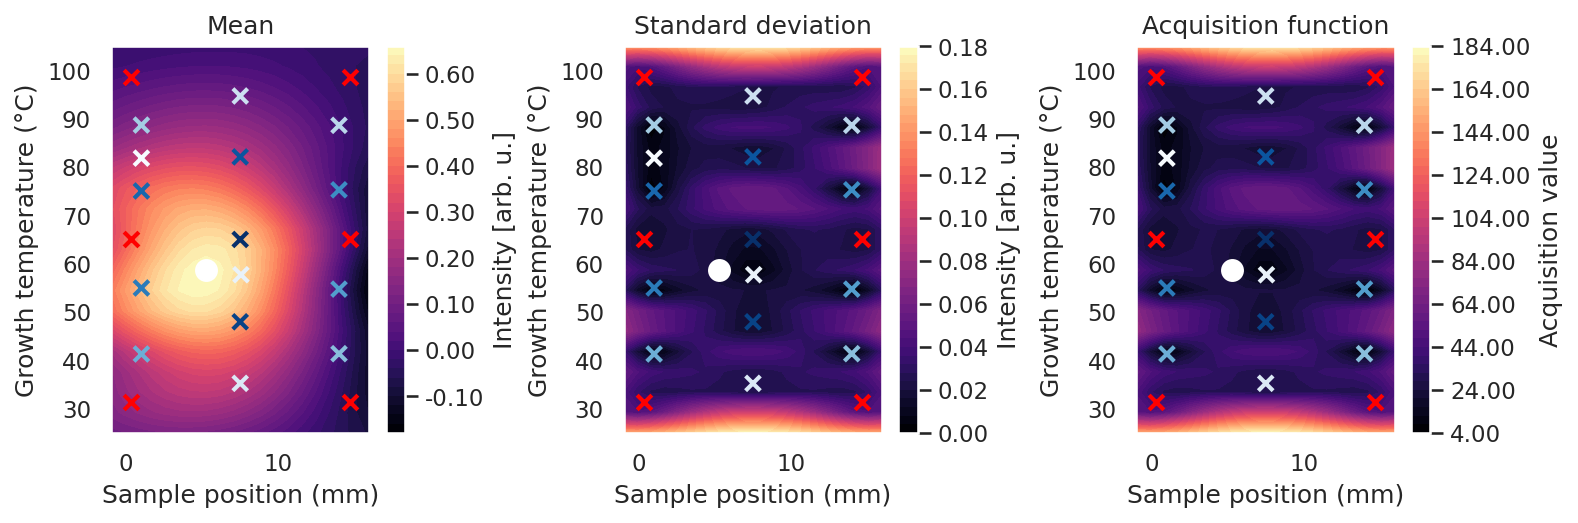

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


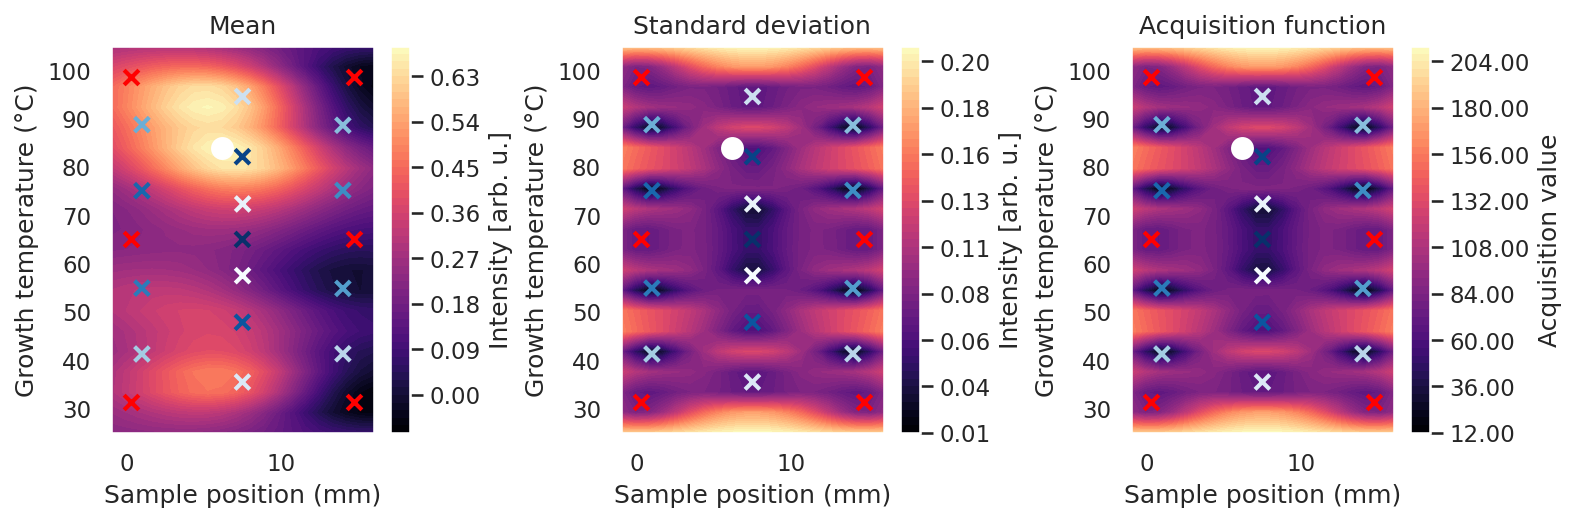

In [31]:
n_iter_list = [15 for i in range(4)]

kappa_strategies = ['balanced', 'linear_exploit', 'constant_exploit', 'constant_explore']

predicted_mean_maps_strategies = []
sampled_points_strategies = []
distances_to_true_maxima_strategies = []
for idx, kappa_strategy in enumerate(kappa_strategies):
    
    print(f'Kappa strategy: {kappa_strategy}')
    
    n_iter = n_iter_list[idx]
    predicted_mean_maps, sampled_points_per_map, distances_to_true_maxima_per_map = loop_through_maps(rbf_interpolators, prediction_grid, x_npoints, y_npoints, DNTT_A_index, DNTT_B_index, Liq_index, n_iter, n_initial_points, max_coords = max_coords_noisy, kappa_strategy = kappa_strategy, plotting = True, bounds=bounds, X0_points=X0_points)
    predicted_mean_maps_strategies.append(predicted_mean_maps)
    sampled_points_strategies.append(sampled_points_per_map)
    distances_to_true_maxima_strategies.append(distances_to_true_maxima_per_map)


### C) Parallelized code for Bayesian optimization

To optimize the computational efficiency of our Bayesian Optimization process, especially when we do not require intermediate plots, parallel processing can be used. This approach allows processing of different kappa strategies while reducing the overall computation time—potentially by approximately 75%.

In [32]:
def process_kappa_strategy(kappa_strategy, n_iter, rbf_interpolators, DNTT_A_index, DNTT_B_index, Liq_index, n_initial_points, bounds=bounds, X0_points=X0_points, prediction_grid=prediction_grid):
    print(f'Processing kappa strategy: {kappa_strategy}')
    # Your loop logic here, returning the necessary results
    predicted_mean_maps, sampled_points, distances_to_true_maxima = loop_through_maps(
        rbf_interpolators, prediction_grid, x_npoints, y_npoints,
        DNTT_A_index, DNTT_B_index, Liq_index,
        n_iter, n_initial_points, max_coords=max_coords_noisy,
        kappa_strategy=kappa_strategy, plotting=False, bounds=bounds,
        X0_points=X0_points,
    )
    return predicted_mean_maps, sampled_points, distances_to_true_maxima


n_iter_list = [15 for i in range(4)]

kappa_strategies = ['balanced', 'linear_exploit', 'constant_exploit', 'constant_explore']

results = Parallel(n_jobs=-1)(
    delayed(process_kappa_strategy)(
        kappa_strategy, n_iter, rbf_interpolators, DNTT_A_index, DNTT_B_index, Liq_index, n_initial_points,
        bounds=bounds, X0_points=X0_points, prediction_grid=prediction_grid
    )
    for kappa_strategy, n_iter in zip(kappa_strategies, n_iter_list)
)

predicted_mean_maps_strategies, sampled_points_strategies, distances_to_true_maxima_strategies = zip(*results)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Processing kappa strategy: balanced
Processing kappa strategy: linear_exploit
Processing kappa strategy: constant_exploit
Processing kappa strategy: constant_explore


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:27<00:00,  1.83s/it]
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:27<00:00,  1.86s/it]
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:31<00:00,  2.10s/it]
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
100%

---
## 7. Comparison of Exploration/Exploitation Samlping Strategies

This chapter contains a comparative analysis of different exploration/exploitation strategies implemented in the Bayesian Optimization process. Our goal is to assess how the different strategies influences the identification of intensity maxima and to evaluate the effectiveness of these strategies in approximating the true data.

### A) Comparison of prediction maps

This chapter contains a comparative analysis of different exploration/exploitation strategies implemented in the Bayesian Optimization process. Our goal is to assess how the different strategies influences the identification of intensity maxima and to evaluate the effectiveness of these strategies in approximating the true data.

One critical aspect of our analysis involves contrasting the intensity maps predicted by the Gaussian models under various strategies against the noisy true maxima. For each strategy, we convert the predicted means into intensity map formats. These maps are presented with both the predicted intensity maxima and the maxima derived from the noisy true maps. Note that the noisy intensity map is plotted with it's maxima as 'Max' and the original true maxima as 'True'.

Both the Balanced and Linear Exploit Strategies generally succeed in accurately identifying the maxima positions. As expected, their predicted intensity fields show significant divergence from the actual intensity field. Repeated runs of the optimization process indicate varying performance levels, with the linear exploit strategy frequently emerging as the more effective approach.

The Constant Exploit Strategy, with its strong focus on prediction mean, often fails to accurately locate the maxima, typically missing the global maxima and settling in local ones instead. This outcome highlights the risk of overemphasis on exploitation at the expense of exploration.

The Constant Exploration Strategy, while effective on the simpler DNTT-A and DNTT-B maps, struggles with more complex maps like the Liq map with its' overlapping Gaussian distributions. Even with increased iterations, the prediction of the exploration strategy does not always converge to the true intensity map as is theoretically expected. This deviation might stem from the implementation of measurement interpolation, discussed further in Chapter 8 'Future Improvements'.

balanced results:


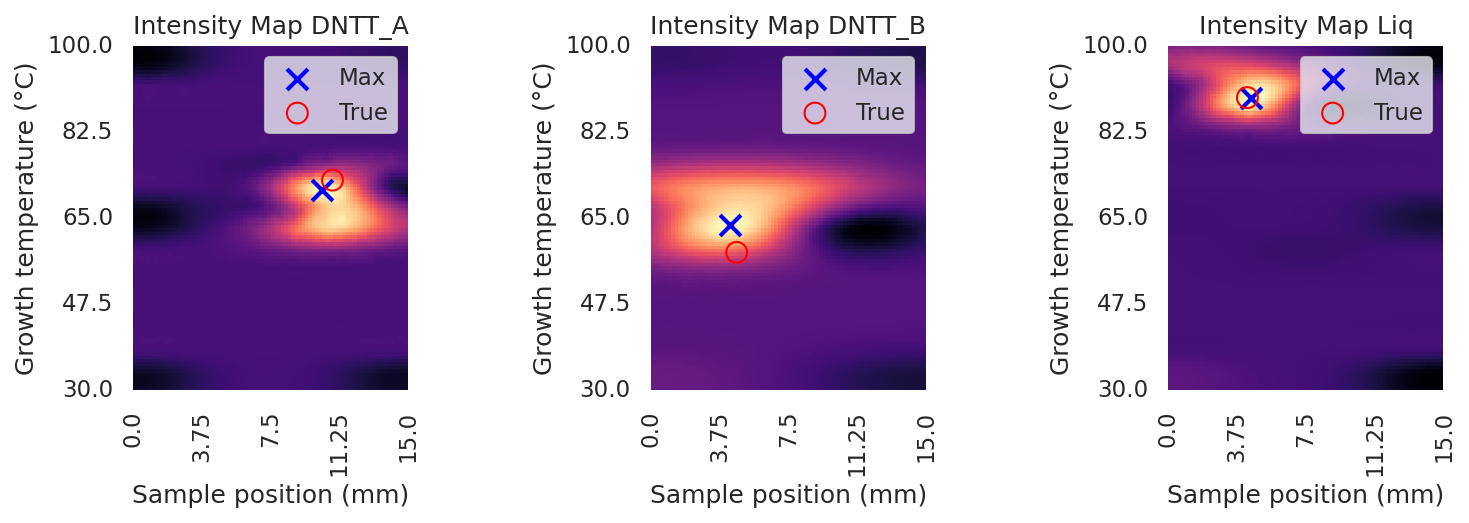

linear_exploit results:


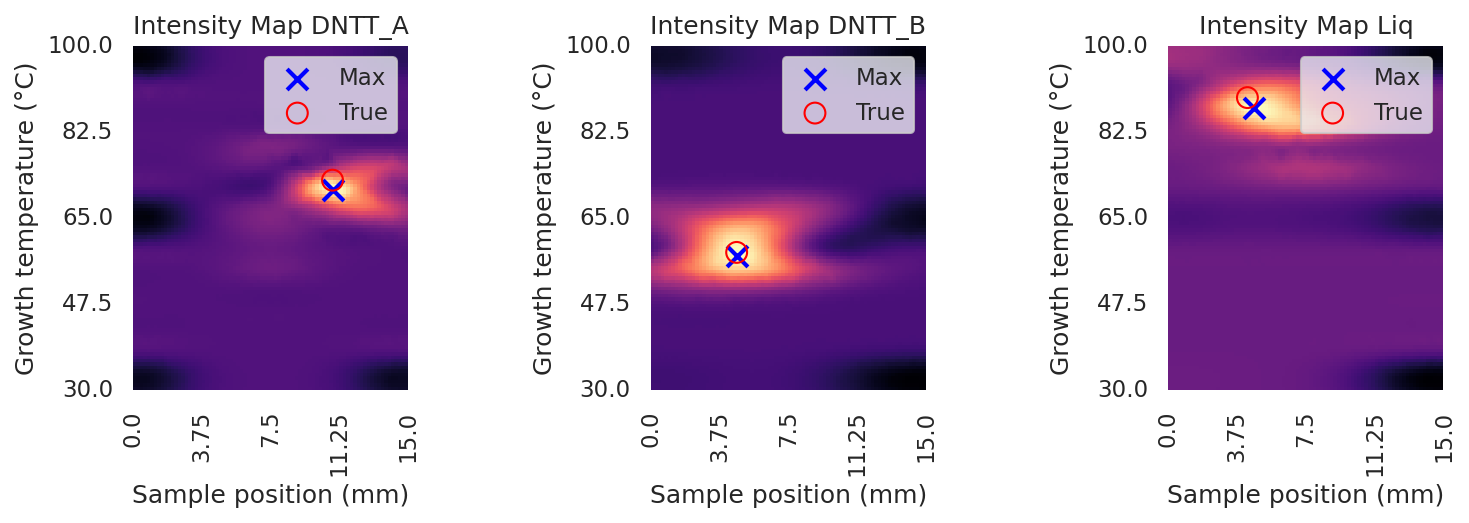

constant_exploit results:


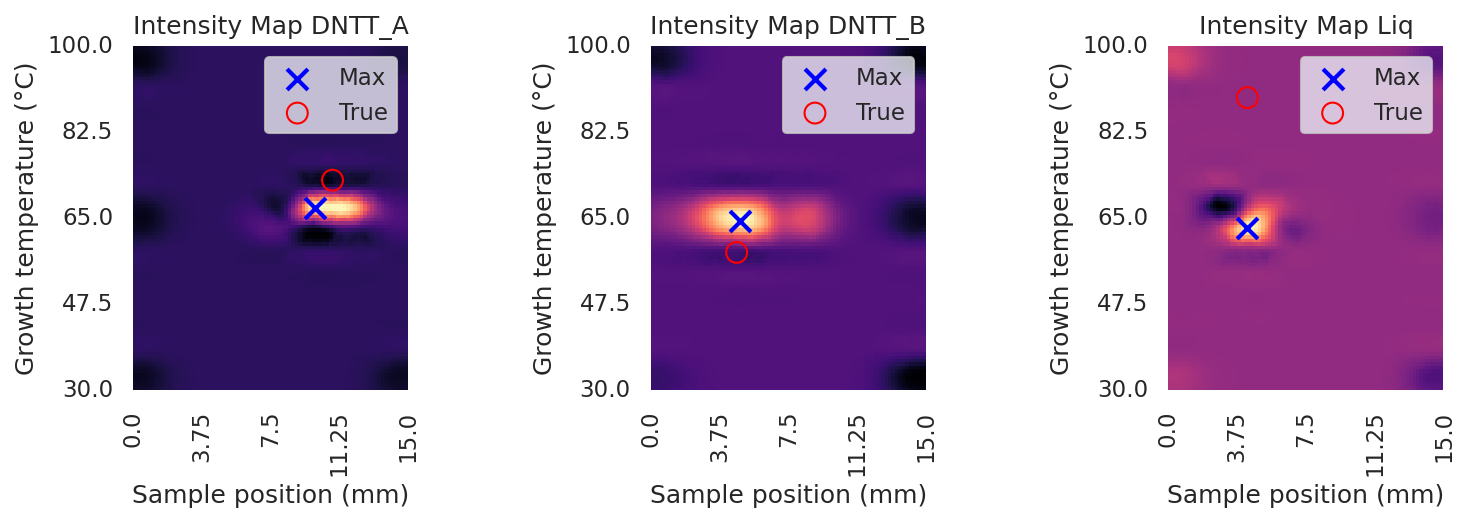

constant_explore results:


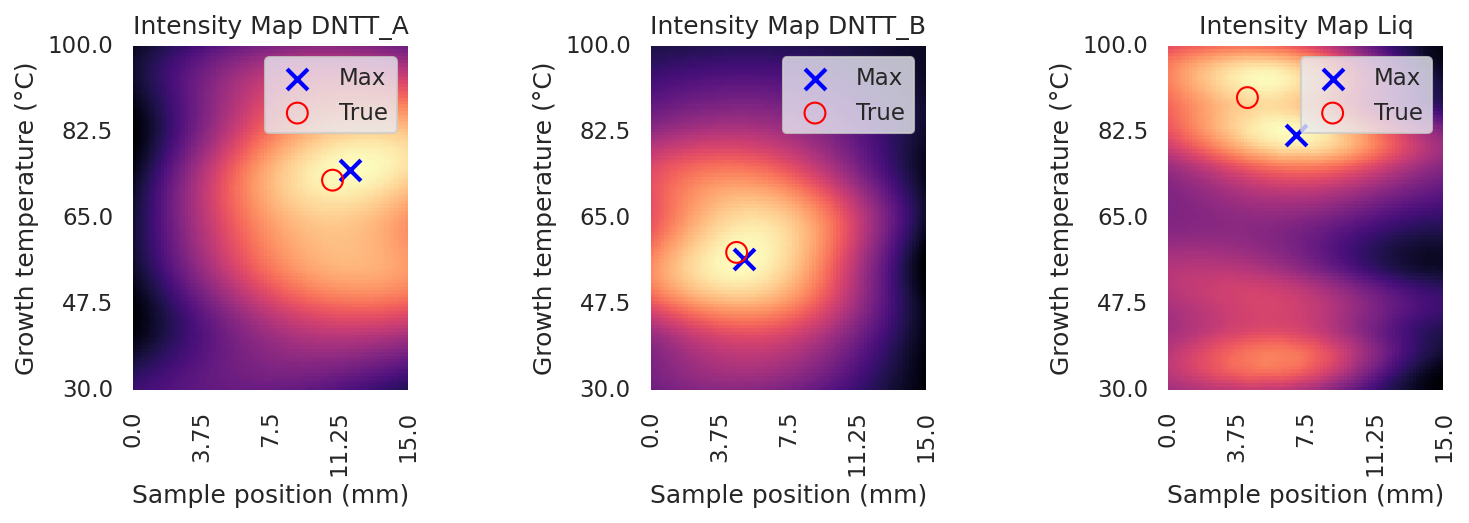

True maps with noise:


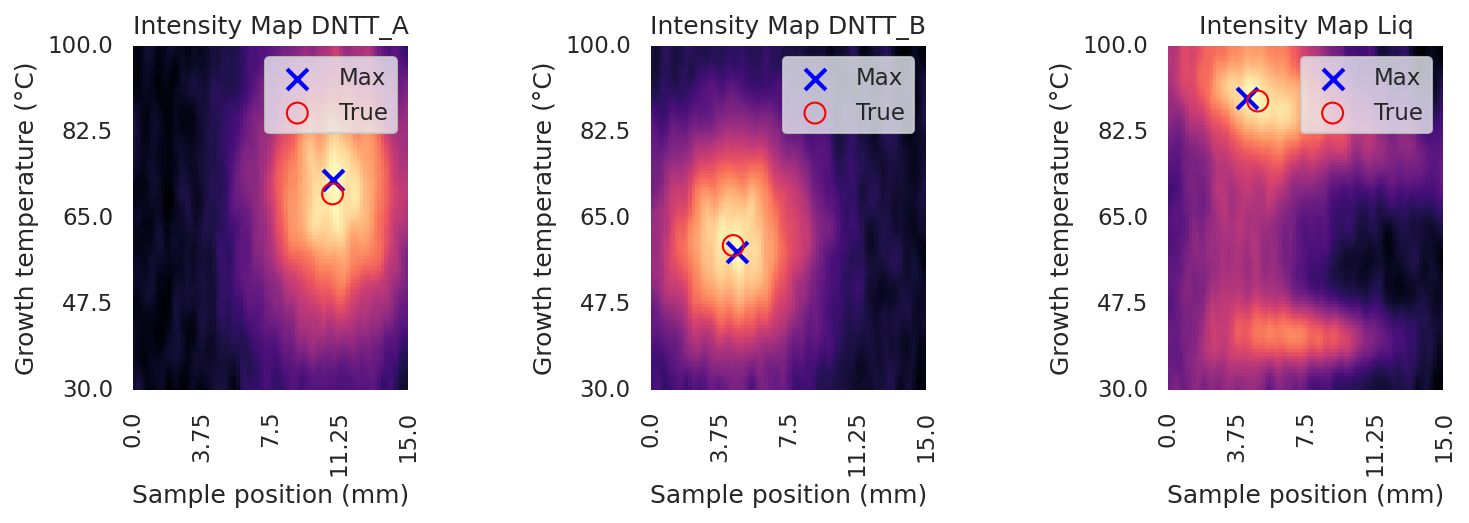

In [33]:
for idx, predicted_mean_maps in enumerate(predicted_mean_maps_strategies):
    
    # Now convert the predicted mean maps
    predicted_intensity_maps = [convert_prediction_map_to_intensity_map(predicted_mean_map, prediction_grid, x, y) for predicted_mean_map in predicted_mean_maps]

    # Get the maximum index for each predicted map
    max_indices_predicted, max_coords_predicted = zip(*[get_intensity_map_maximum(predicted_intensity_map, x, y) for predicted_intensity_map in predicted_intensity_maps])

    print(kappa_strategies[idx], 'results:')
    # And plot them
    plot_intensity_maps(predicted_intensity_maps, x, y, labels=labels, max_indices=max_indices_predicted, true_indices=max_indices_noisy)

print("True maps with noise:")
plot_intensity_maps([DNTT_A_map, DNTT_B_map, Liq_map], x, y, labels=labels, max_indices=max_indices_noisy, true_indices=max_indices)

### B) Comparison of Convergence and Sampling Efficiency

The convergence behavior of various sampling strategies reveals their efficiency in identifying the true intensity maxima in comparison to traditional grid search methods. 

First, we plot the distance from each strategy's sampled points to the noisy true maxima over time, providing a summary of each strategy's performance. The horizontal lines representing the grid search results act as benchmarks, demonstrating the capacity of Bayesian Optimization to surpass traditional methods. Notably, except for the constant exploration strategy, all strategies demonstrate convergence toward sampling coordinates that are closer to the true maxima than those obtained from grid searches. The linear exploit strategy's sampling exhibits the most impressive performance, converging closer to the noisy maxima than the large grid search while only utilizing a fifth of the measurements. In certain applications of Bayesian Optimization, the computationally intensive task of pinpointing the maxima of the mean prediction grid at each iteration is bypassed; instead, the converging sampling coordinates are accepted as the conclusive result for the maximum intensity.

Secondly, to assess the performance of the exploration strategy—where sampling does not converge to the predicted mean maxima, we also examine the convergence of the predicted maxima. Remarkably, the predicted mean intensity for the linear exploit strategy outshines the large grid search with a mere 8 measurements (including 6 initial ones) for the DNTT-A and DNTT-B maps, and just 10 measurements for the more complex Liq intensity map. These findings imply that strategies like balanced and linear exploit are useful in scenarios that demand high sampling efficiency. On the other hand, the constant exploration strategy’s slower convergence underscores its preference for general overview as opposed as rapid maxima identification. 

We have thus shown that the strategy best suited for a given application depends on the specific goals and constraints of the experimental setup.

In [34]:
# Plot the convergence of the sampling
#
####################################################################################################

def plot_sampling_convergence(sampled_points_strategies, kappa_strategies, n_initial_points, max_coords=max_coords_noisy, grid_distances_size = None):
    
    """
    Description:
    Function to plot the convergence of the sampling.
    
    Inputs:
    sampled_points_strategies (list): List of 2D arrays of the sampled measurement coordinates
    kappa_strategies (list): List of kappa strategies
    n_initial_points (int): Number of initial points
    max_coords (list): List of tuples of the true maxima
    grid_distances_size (list): List of 2D arrays of the distances to the grid points
    
    Outputs:
    sampled_point_distance_to_true_maxima_maps (list): List of 2D arrays of the distances to the true maxima
    
    """    
    
    # Number of maps
    num_maps = len(sampled_points_strategies[0])
    
    fig, axes = plt.subplots(1, num_maps, figsize=(5 * num_maps, 3.5))  # Adjust figure size as needed

    true_maxima = np.array(max_coords)

    # Loop over each map
    sampled_point_distance_to_true_maxima_maps = []
    
    for map_idx in range(num_maps):
        ax = axes[map_idx]  # Get the current axis for the subplot
        
        # Loop over each strategy
        sampled_point_distance_to_true_maxima_strategies = []
        for strategy_idx, strategy_sampled_points in enumerate(sampled_points_strategies):
            sampled_points = strategy_sampled_points[map_idx]  # Sampled points for the current map and strategy
            
            # Calculate distances for current strategy and map
            distances_to_true_maxima = np.linalg.norm(sampled_points - true_maxima[map_idx], axis=1)
            
            sampled_point_distance_to_true_maxima_strategies.append(distances_to_true_maxima)
            
            # Plot distances on the current subplot
            ax.plot(distances_to_true_maxima, label=f'{kappa_strategies[strategy_idx]}')
            
            if n_initial_points is not None:
                ax.vlines(n_initial_points, np.min(distances_to_true_maxima), np.max(distances_to_true_maxima), linestyle='--', color='black')
                
        if n_initial_points is not None:
            ax.plot([], [], linestyle='--', color='black', label='Initial points')
        
        grid_labels = ['Small, 49 points', 'Large, 100 points']
        grid_colors = ['darkred', 'darkblue']
        linestyle = ['--', '-']
        markers = ['o', 'x']
        if grid_distances_size is not None:
            for grid_size_idx, grid_distances in enumerate(grid_distances_size):
                ax.plot([0, len(distances_to_true_maxima)], [grid_distances[:][map_idx], grid_distances[:][map_idx]], color = grid_colors[grid_size_idx], linestyle='--', marker = markers[grid_size_idx], label=grid_labels[grid_size_idx])

        
        ax.set_title(f'Intensity Map {labels[map_idx]}')
        ax.set_xlabel('Number of samples')
        ax.set_ylabel('Distance to true maxima')
        ax.legend(loc = 'upper left')

        sampled_point_distance_to_true_maxima_maps.append(sampled_point_distance_to_true_maxima_strategies)
    
    fig.suptitle('Distance between sampled point and (noisy) true maxima', fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return sampled_point_distance_to_true_maxima_maps
    
    
def plot_distance_to_maxima(distances_to_true_maxima_strategies, kappa_strategies, n_initial_points, max_coords=max_coords, grid_distances_size = None):
    """
    Description:
    Function to plot the convergence of predicted intensity maxima.
    
    Inputs:
    distances_to_true_maxima_strategies (list): List of 2D arrays of the distances to the true maxima
    kappa_strategies (list): List of kappa strategies
    n_initial_points (int): Number of initial points
    max_coords (list): List of tuples of the true maxima
    grid_distances_size (list): List of 2D arrays of the distances to the grid points
    
    Outputs:
    None
    
    """
    # Number of maps
    num_maps = len(distances_to_true_maxima_strategies[0])
    
    fig, axes = plt.subplots(1, num_maps, figsize=(5 * num_maps, 3.5))  # Adjust figure size as needed

    true_maxima = np.array(max_coords)

    # Loop over each map
    for map_idx in range(num_maps):
        ax = axes[map_idx]  # Get the current axis for the subplot
        
        # Loop over each strategy
        for strategy_idx, strategy_distances_to_true_maxima in enumerate(distances_to_true_maxima_strategies):
            distances_to_true_maxima = strategy_distances_to_true_maxima[map_idx]  # Distances to true maxima for the current map and strategy
            
            # Offset the x-values by n_initial_points
            x_values = np.arange(n_initial_points, n_initial_points + len(distances_to_true_maxima))
            
            # Plot distances on the current subplot
            ax.plot(x_values, distances_to_true_maxima, label=f'{kappa_strategies[strategy_idx]}')
        
        grid_labels = ['Small, 49 points', 'Large, 100 points']
        grid_colors = ['darkred', 'darkblue']
        linestyle = ['--', '-']
        markers = ['o', 'x']
        if grid_distances_size is not None:
            for grid_size_idx, grid_distances in enumerate(grid_distances_size):
                #ax.hlines(grid_distances[:][map_idx], n_initial_points, n_initial_points + len(distances_to_true_maxima), color = grid_colors[grid_size_idx], marker=markers[grid_size_idx], label=grid_labels[grid_size_idx], linestyle='--')
                ax.plot([x_values[0], x_values[-1]], [grid_distances[:][map_idx], grid_distances[:][map_idx]], color = grid_colors[grid_size_idx], linestyle='--', marker = markers[grid_size_idx], label=grid_labels[grid_size_idx])

        # Automattically set the number of ticks on the x-axis
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        ax.set_title(f'Intensity Map {map_idx + 1}')  # Assuming you want to start map index from 1
        ax.set_xlabel('Number of samples')
        ax.set_ylabel('Distance to true maxima')
        ax.legend(loc = 'upper left')
        
    fig.suptitle('Distance between predicted and (noisy) true maxima', fontsize=16)
    plt.tight_layout()
    plt.show()

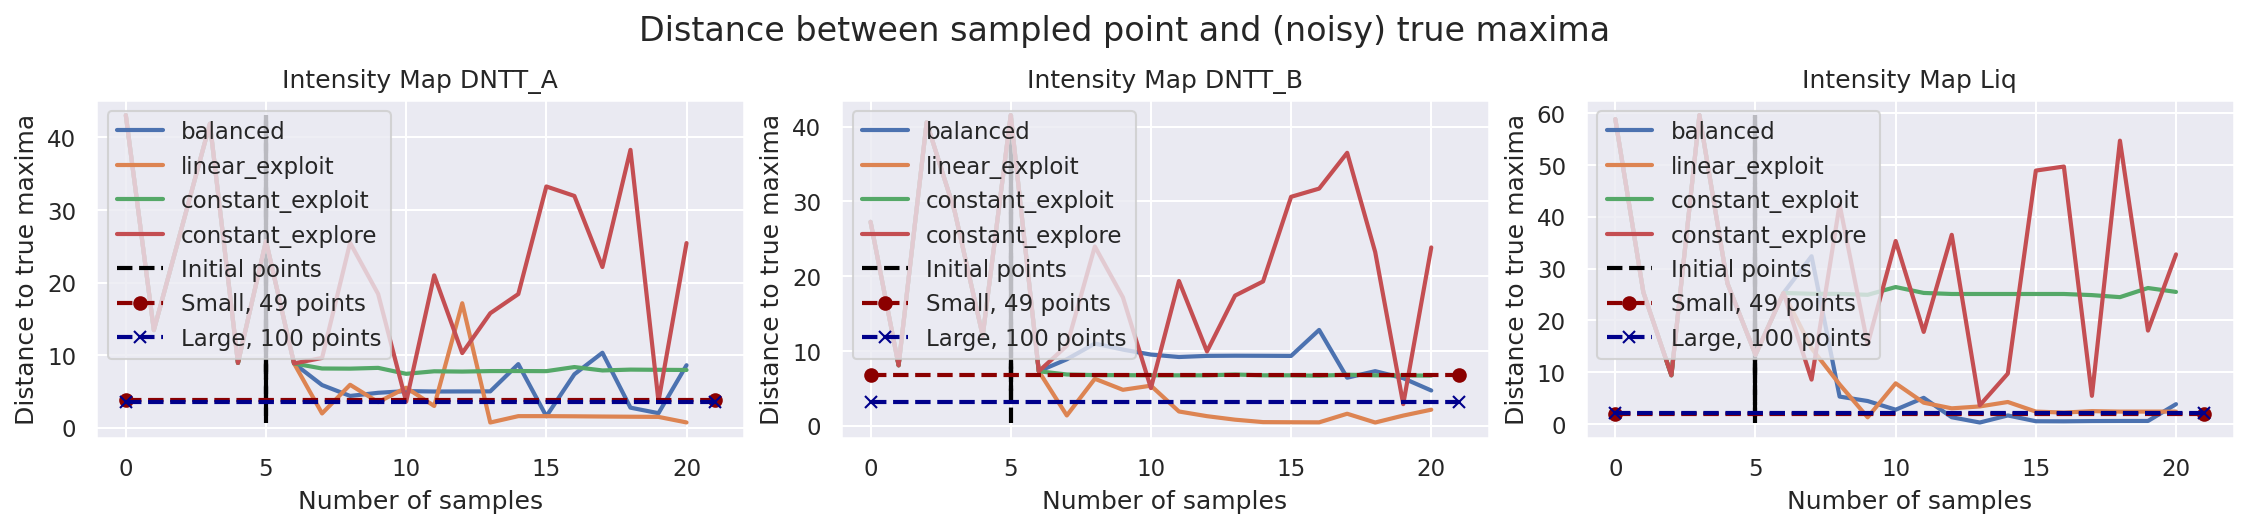

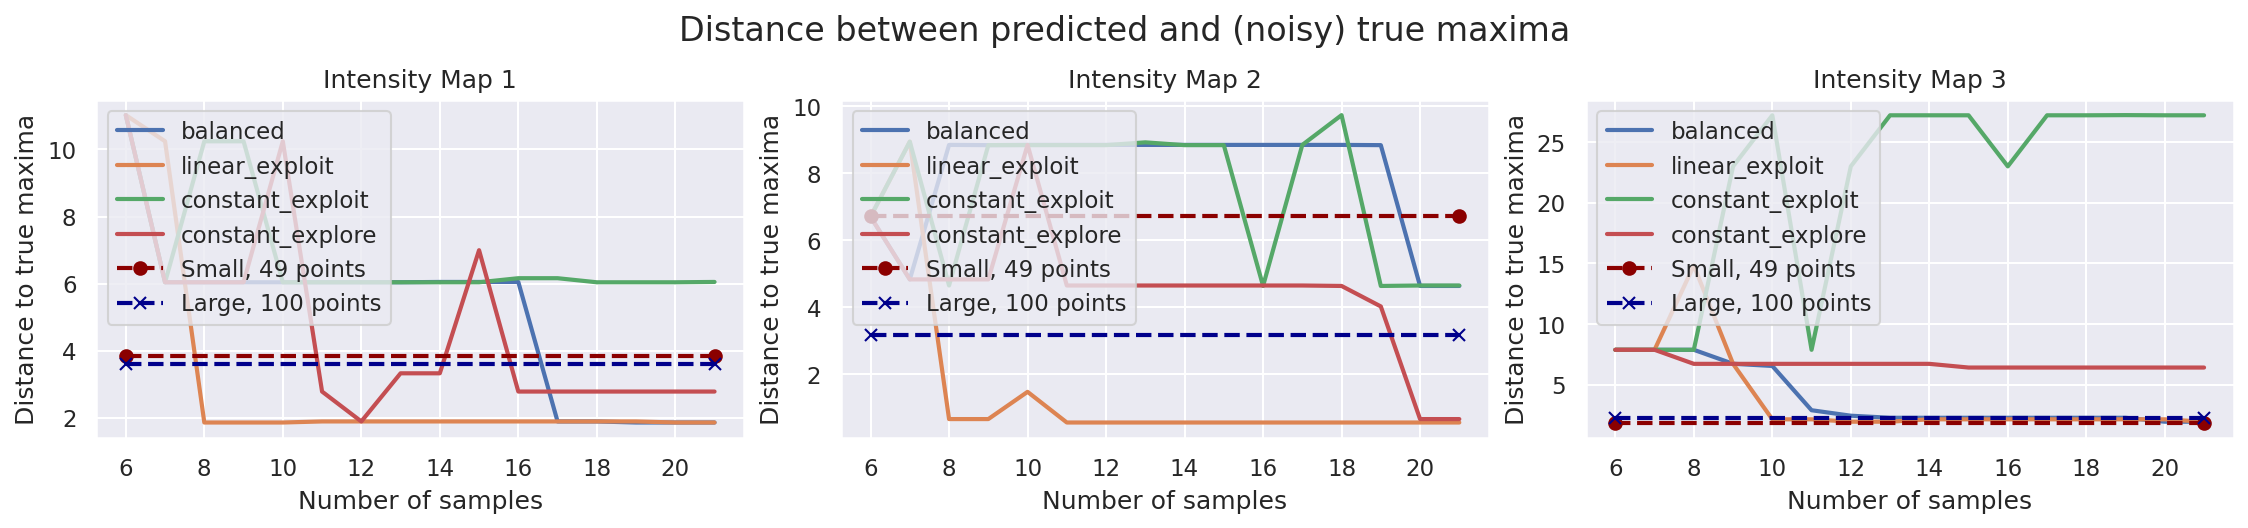

In [35]:
grid_distances_size = []
for max_coords_grid_maps in [max_coords_grid_search_small, max_coords_grid_search_large]:
    grid_distances = []
    for map_idx, max_coords in enumerate(max_coords_grid_maps):
        grid_distances.append(np.linalg.norm(np.array(max_coords_noisy[map_idx]) - np.array(max_coords)))
    grid_distances_size.append(grid_distances)


sampled_point_distance_to_true_maxima_maps = plot_sampling_convergence(sampled_points_strategies, kappa_strategies, n_initial_points-1, max_coords=max_coords_noisy, grid_distances_size = grid_distances_size)

plot_distance_to_maxima(distances_to_true_maxima_strategies, kappa_strategies, n_initial_points, max_coords=max_coords_noisy, grid_distances_size = grid_distances_size)


---
## 8. Future improvements

Reflecting on the Bayesian Optimization process applied in this study, several improvements emerge as opportunities to boost efficiency, precision, and adaptability.

A primary concern is the interpolation method used to simulate measurements, which may be adversely affecting performance, particularly under the Constant Exploration Sampling Strategy. The interpolation appears especially prone to inaccuracies when faced with the smeared noise characteristic of overlapping Gaussian distributions. A proposed alternative is to simulate measurements through calculated mathematical functions, which could more accurately represent the true intensity distributions.

In addition to refining measurement simulation, the application of cross-validation techniques for hyperparameter optimization could enhance model performance. Specifically, cross-validation could be used to identify optimal hyperparameters for both the Gaussian Process model and the associated exploration/exploitation strategies. 

One might also introduce dynamic adjustments of kappa values relative to the number of iterations could yield a more sophisticated exploration/exploitation balance. Normalizing kappa by the iteration count might disclose more nuanced sampling behavior and enable more consistent comparisons between strategies over varied iteration spans.

Lastly, to improve upon this notebook and benchmark the strategies more robustly, it would be beneficial to run multiple iterations of the Bayesian Optimizations. Recording the final sample and predicted maxima distances to the true maxima, and tracking the iteration count until the predicted maxima surpass the accuracy of a large grid search, would provide a more comprehensive performance overview. This would not only highlight the relative efficiency of different strategies but also underscore the stochastic nature of Bayesian Optimization's proposed measurements.